# House price predictions for the kaggle competition

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
from IPython.display import display
import math
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score,r2_score, log_loss, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import probplot as qqplot
from sklearn.svm.libsvm import predict_proba # need for the log_loss metric
import warnings

In [3]:
# Settings

In [4]:
pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.max_columns', 500)
plt.style.use('ggplot')
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None
print(plt.rcParams.get('figure.figsize'))
plt.rcParams['figure.figsize'] = (6, 4)
%matplotlib inline  
 

[8.0, 5.5]


# Definitions

In [5]:
   

#__________________unpredictedSalesPrice,realSalesPrice,predictorObservationsc:tions__________________
def calc_rmse(sumofresids, n):#Equal name: rms-Deviation. RMSE=Variance(of y-hat) + Bias (of y-hat and y)
    """
    Args:
    sum of resids (int):sum of squared residuals
    n (int): sample size
    
    Returns:
    rmse (float): root mean of sum of squared residuals
    
    """ 
    
    rmse = math.sqrt(sumofresids/n)
    return rmse


def calc_avg_deviation(predictedSalesPrice,realSalesPrice):
    """
    Args:
        predictedSalesPrice (ndarray):
        realSalesPrice (ndarray):
    
    Returns:
        avg residue
    """
    # put all args into a dataframs
    # calc residues and avg bias
    dferror = pd.DataFrame( data = predictedSalesPrice, columns=['PredictedSalesPrice'], copy = True)
    
    dferror['SalePrice']=realSalesPrice
    
    dferror['Residues']=dferror.PredictedSalesPrice-dferror.SalePrice
  
    # square residues and sum em up
    avg_deviation = dferror.Residues.sum()/dferror.shape[0]
  
    return avg_deviation

    
def calc_max_deviation(predictedSalesPrice,realSalesPrice):
    """
    Args:
        predictedSalesPrice (ndarray):
        realSalesPrice (ndarray):
    
    Returns:
        avg bias
    """
    # put all args into a dataframs
    # calc residues and avg bias
    dferror = pd.DataFrame( data = predictedSalesPrice, columns=['PredictedSalesPrice'], copy = True)
    
    dferror['SalePrice']=realSalesPrice
    
    dferror['Residues']=dferror.PredictedSalesPrice-dferror.SalePrice
    
    dferror['Absolute_Residues']=dferror['Residues'].apply(lambda x: np.sqrt(x*x))
  
    # square residues and sum em up
    max_dev = dferror['Absolute_Residues'].max()
  
    return max_dev
    


def calc_r_squared_by_hand (predictedSalesPrice,realSalesPrice):
    """
    Args:

    :return:
    """
    dferror = pd.DataFrame( data = predictedSalesPrice, columns=['PredictedSalesPrice'], copy = True)
    dferror['SalePrice']=realSalesPrice
    dferror['Residues']=dferror.PredictedSalesPrice-dferror.SalePrice
    dferror['Deviation_true_y_from_mean'] = dferror['SalePrice']-dferror['SalePrice'].mean()
    explained_variance = dferror.Residues.apply(lambda x: x*x).sum()
    total_variance = dferror.Deviation_true_y_from_mean.apply(lambda x: x*x).sum()
    r_squared = 1-explained_variance/total_variance
    print("R^2 by hand: ", r_squared)
    
    
def calc_r_sq_by_hand (predictedSalesPrice,realSalesPrice):
    """
    Args:

    :return:
    """
    dferror = pd.DataFrame( data = predictedSalesPrice, columns=['PredictedSalesPrice'], copy = True)
    dferror['SalePrice']=realSalesPrice
    dferror['Residues']=dferror.PredictedSalesPrice-dferror.SalePrice
    dferror['Deviation_true_y_from_mean'] = dferror['SalePrice']-dferror['SalePrice'].mean()
    explained_variance = dferror.Residues.apply(lambda x: x*x).sum()
    total_variance = dferror.Deviation_true_y_from_mean.apply(lambda x: x*x).sum()
    r_squared = 1-explained_variance/total_variance
    return r_squared

def calc_adj_r_sq_by_hand (predictedSalesPrice,realSalesPrice, p):
    """
    Args:
        p number of features
        
    """

    dferror = pd.DataFrame( data = predictedSalesPrice, columns=['PredictedSalesPrice'],\
                           copy = True)
    dferror['SalePrice']=realSalesPrice
    dferror['Residues']=dferror.PredictedSalesPrice-dferror.SalePrice
    dferror['Deviation_true_y_from_mean'] = dferror['SalePrice']-dferror['SalePrice'].mean()
    explained_variance = dferror.Residues.apply(lambda x: x*x).sum()
    total_variance = dferror.Deviation_true_y_from_mean.apply(lambda x: x*x).sum()
    r_squared = 1-explained_variance/total_variance
    n = dferror.shape[0]
    adj_r_squared = 1-(1-r_squared)*((n-1)/(n-p-1))
    return adj_r_squared


def makeOutputFile(df,col, number):
    """
    Args:
    df (dataframe):
    col(str): name of the column width predicted values
    number (int): index of output file
    """
    df.to_csv('My_submission_'+str(number)+'.csv',index=True,columns=[col], index_label='Id')
    print("\n **************** Output written to: 'My_submission_{}.csv' \n".format(number))

    
def calc_rmse_logrmse_by_hand(predictedSalesPrice,realSalesPrice,predictorObservations):
    """
    Args:
    predictedSalesPrice (ndarray):
    realSalesPrice (ndarray):
    predictorObservations (ndarray):
    
    Returns:
    prints RMSE and LOGRMSE
    """
    # put all args into a dataframs
    # calc residues and log residues by hand
    dferror = pd.DataFrame( predictorObservations, copy = True)
    dferror['PredictedSalesPrice'] = predictedSalesPrice
    dferror['SalePrice']=realSalesPrice
    dferror['Residues']=dferror.PredictedSalesPrice-dferror.SalePrice
    dferror['LogResidues']=(dferror.PredictedSalesPrice.apply(lambda x: np.log(x)))-\
                                    (dferror.SalePrice.apply(lambda x: np.log(x)))
    # square residues and sum em up
    squaredsumoferrors = dferror.Residues.apply(lambda x: x*x).sum()
    squaredsumoflogerrors = dferror.LogResidues.apply(lambda x: x*x).sum()
    
    print ("RMSE by Hand:", calc_rmse(squaredsumoferrors, dferror.shape[0]))
    print ("LOGRMSE by Hand:", calc_rmse(squaredsumoflogerrors, dferror.shape[0]))
    
def calc_rmse_by_hand(predictedSalesPrice,realSalesPrice,predictorObservations):
    """
    Args:
    predictedSalesPrice (ndarray):
    realSalesPrice (ndarray):
    predictorObservations (ndarray):
    
    Returns:
    prints RMSE and LOGRMSE
    """
    # put all args into a dataframs
    # calc residues and log residues by hand
    dferror = pd.DataFrame( predictorObservations, copy = True)
    dferror['PredictedSalesPrice'] = predictedSalesPrice
    dferror['SalePrice']=realSalesPrice
    dferror['Residues']=dferror.PredictedSalesPrice-dferror.SalePrice
    dferror['LogResidues']=(dferror.PredictedSalesPrice.apply(lambda x: np.log(x)))-\
                                    (dferror.SalePrice.apply(lambda x: np.log(x)))
    # square residues and sum em up
    squaredsumoferrors = dferror.Residues.apply(lambda x: x*x).sum()
    squaredsumoflogerrors = dferror.LogResidues.apply(lambda x: x*x).sum()
    
    return calc_rmse(squaredsumoferrors, dferror.shape[0])
    
def calc_logrmse_by_hand(predictedSalesPrice,realSalesPrice,predictorObservations):
    """
    Args:
    predictedSalesPrice (ndarray):
    realSalesPrice (ndarray):
    predictorObservations (ndarray):
    
    Returns:
    prints RMSE and LOGRMSE
    """
    # put all args into a dataframs
    # calc residues and log residues by hand
    dferror = pd.DataFrame( predictorObservations, copy = True)
    dferror['PredictedSalesPrice'] = predictedSalesPrice
    dferror['SalePrice']=realSalesPrice
    dferror['Residues']=dferror.PredictedSalesPrice-dferror.SalePrice
    dferror['LogResidues']=(dferror.PredictedSalesPrice.apply(lambda x: np.log(x)))-\
                                    (dferror.SalePrice.apply(lambda x: np.log(x)))
    # square residues and sum em up
    squaredsumoferrors = dferror.Residues.apply(lambda x: x*x).sum()
    squaredsumoflogerrors = dferror.LogResidues.apply(lambda x: x*x).sum()
    
    
    return calc_rmse(squaredsumoflogerrors, dferror.shape[0])
    
def calc_rmse_logrmse_by_hand2(realSalesPrice,predictedSalesPrice):
    """
    Args:
    predictedSalesPrice (ndarray):
    realSalesPrice (ndarray):
    predictorObservations (ndarray):
    
    Returns:
    prints RMSE and LOGRMSE
    """
    # put all args into a dataframs
    # calc residues and log residues by hand
    dferror = pd.DataFrame(Y_train, np.arange(Y_train.shape[0]), ['PredictedSalesPrice'])
    print(dferror.head())
    #dferror['PredictedSalesPrice'] = predictedSalesPrice
    dferror['SalePrice']=realSalesPrice
    dferror['Residues']=dferror.PredictedSalesPrice-dferror.SalePrice
    dferror['LogResidues']=(dferror.PredictedSalesPrice.apply(lambda x: np.log(x)))-\
                                    (dferror.SalePrice.apply(lambda x: np.log(x)))
    # square residues and sum em up
    squaredsumoferrors = dferror.Residues.apply(lambda x: x*x).sum()/dferror.shape[0]
    squaredsumoflogerrors = dferror.LogResidues.apply(lambda x: x*x).sum()
    
    #print ("RMSE by Hand:", calc_rmse(squaredsumoferrors, dferror.shape[0]))
    #print ("LOGRMSE by Hand:", calc_rmse(squaredsumoflogerrors, dferror.shape[0]))
    print(dferror.head())
    return squaredsumoferrors

def calc_rmse_logrmse_by_hand3(realSalesPrice,predictedSalesPrice):
    """
    Args:
    predictedSalesPrice (ndarray):
    realSalesPrice (ndarray):
    predictorObservations (ndarray):
    
    Returns:
    prints RMSE and LOGRMSE
    """
    # put all args into a dataframs
    # calc residues and log residues by hand
    dferror = pd.DataFrame( predictedSalesPrice, columns = ['PredictedSalesPrice'], copy = True)
    #dferror['PredictedSalesPrice'] = predictedSalesPrice
    dferror['SalePrice']=realSalesPrice
    dferror['Residues']=dferror.PredictedSalesPrice-dferror.SalePrice
    dferror['LogResidues']=(dferror.PredictedSalesPrice.apply(lambda x: np.log(x)))-\
                                    (dferror.SalePrice.apply(lambda x: np.log(x)))
    # square residues and sum em up
    squaredsumoferrors = dferror.Residues.apply(lambda x: x*x).sum()
    squaredsumoflogerrors = dferror.LogResidues.apply(lambda x: x*x).sum()
    
    #print ("RMSE by Hand:", calc_rmse(squaredsumoferrors, dferror.shape[0]))
    #print ("LOGRMSE by Hand:", calc_rmse(squaredsumoflogerrors, dferror.shape[0]))

    return calc_rmse(squaredsumoflogerrors, dferror.shape[0])


def plot_residues(predictedSalesPrice,realSalesPrice,predictorObservations):
    """
    Args:
        predictedSalesPrice (ndarray):
        realSalesPrice (ndarray):
        predictorObservations (ndarray):
    
    Returns:
        plot: residues vs. predicted target
    """
        
    # put all args into a dataframs
    # calc residues and log residues by hand
    dferror = pd.DataFrame( data = predictorObservations)
    dferror['PredictedSalesPrice'] = predictedSalesPrice
    dferror['SalePrice']=realSalesPrice
    dferror['Residues']=dferror.PredictedSalesPrice-dferror.SalePrice
    dferror['LogResidues']=(dferror.PredictedSalesPrice.apply(lambda x: np.log(x)))-\
                                    (dferror.SalePrice.apply(lambda x: np.log(x)))
    # square residues and sum em up
    squaredsumoferrors = dferror.Residues.apply(lambda x: x*x).sum()
    squaredsumoflogerrors = dferror.LogResidues.apply(lambda x: x*x).sum()
    
    fig=plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.set_title('Residue plot')
    ax1.set_xlabel('Predicted SalePrice')
    ax1.set_ylabel('Residues')
    ax1.scatter(dferror.PredictedSalesPrice,dferror.Residues, color='red')
    ax2.scatter(dferror.PredictedSalesPrice,dferror.LogResidues, color='blue')
    ax2.set_title('Log residue plot')
    ax2.set_xlabel('Predicted SalePrice')
    ax2.set_ylabel('Log residues')
    plt.show()
    

def plot_residues_boxed(predictedSalesPrice,realSalesPrice,predictorObservations):
        """
        """
    
        dferror = pd.DataFrame( data = predictorObservations)
        dferror['PredictedSalesPrice'] = predictedSalesPrice
        dferror['SalePrice']=realSalesPrice
        dferror['Residues']=dferror.PredictedSalesPrice-dferror.SalePrice
        dferror['LogResidues']=(dferror.PredictedSalesPrice.apply(lambda x: np.log(x)))-\
                                        (dferror.SalePrice.apply(lambda x: np.log(x)))


        binz = [dferror['PredictedSalesPrice'].min() - 1,
        dferror['PredictedSalesPrice'].quantile(.1),
        dferror['PredictedSalesPrice'].quantile(.2),
        dferror['PredictedSalesPrice'].quantile(.3),
        dferror['PredictedSalesPrice'].quantile(.4),
        dferror['PredictedSalesPrice'].quantile(.5),
        dferror['PredictedSalesPrice'].quantile(.6),
        dferror['PredictedSalesPrice'].quantile(.7),
        dferror['PredictedSalesPrice'].quantile(.8),
        dferror['PredictedSalesPrice'].quantile(.9),
        dferror['PredictedSalesPrice'].max()
        ]

        dferror['Status'] = pd.cut(dferror['PredictedSalesPrice'], bins=binz)

        fig, (ax1,ax2) =plt.subplots(1,2,figsize=(15, 6))

        sns.boxplot(dferror['Status'],\
                    dferror['Residues'], ax=ax1)

        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
        ax1.set_ylim((-150000,150000))
        ax1.set_xlabel('Predicted SalePrice')
        ax1.set_title('Residue plot')


        sns.boxplot(dferror['Status'],\
                    dferror['LogResidues'], ax=ax2)

        ax2.set_xlabel('Predicted SalePrice')

        ax2.set_title('Log residue plot')

        plt.xticks(rotation=90)

        plt.ylim((-1.5,1.5))

        plt.show()
    
    
    
def plot_real_and_predicted_values(predictor,true_target,predicted_target, intercept, coef):
    """
    Args:
        predictedSalesPrice (ndarray):
        realSalesPrice (ndarray):
        predictorObservations (ndarray):
        intercept (float): intercept of the regression line
        coef (float): coefficient of the regression line
    Returns:
        plot: scatters the test-split of the training data vs. the predictor
              scatters the predicted target from linreg.predict vs. the predictor.
              scatters the predicted target, calculated from the line eq. vs. the predictor.
              
    """
        
    predict_by_line_eq = lambda x: intercept + coef*x
    predicted_target_by_line_eq = predict_by_line_eq(predictor)
    
    fig=plt.figure()#figure object=container
    #create axes object. add_axes also creates this type oj object but with different positioning
    ax=fig.add_subplot(1,1,1)
    ax.set_title('Real and predicted values')
    ax.set_xlabel('Predictor')
    ax.set_ylabel('SalePrice')
    ax.scatter(predictor,true_target, color='black')
    ax.scatter(predictor, predicted_target, color='red')
    ax.scatter(predictor, predicted_target_by_line_eq, color='green', s = 5)
    plt.show()
    
#__________________Classes__________________
class errorDf:

    def __init__(self,predictedSalesPrice,realSalesPrice,predictorObservations,model):

        dferror=pd.DataFrame(data=predictedSalesPrice, columns=['Predicted'])
        dferror['SalePrice']=realSalesPrice
        dferror['Residues']=dferror.Predicted-dferror.SalePrice
        dferror['LogResidues']=(dferror.Predicted.apply(lambda x: np.log(x)))-\
                                    (dferror.SalePrice.apply(lambda x: np.log(x)))
        self.squaredsumoferrors = dferror.Residues.apply(lambda x: x*x).sum()
        self.squaredsumoflogerrors = dferror.LogResidues.apply(lambda x: x*x).sum()
        self.beobachtungen = predictorObservations
        self.zielVariable=realSalesPrice
        self.vorhersageZielVariable = predictedSalesPrice
        self.anzahlBeobachtungen = len(dferror)
        self.errorframe= dferror
        self.linreg = model
        
    def reportError(self):
         print("Intercept:",self.linreg.intercept_)
         print("Coefficient(s):", self.linreg.coef_)
         print("Sum of Residues:", self.linreg.residues_)#Sum of residuals. Squared Euclidean 2-norm for each target passed during the fit
         print("RMSE:", calc_rmse(self.linreg.residues_, len(df_train)))#
         # arg:1 train/test predictor arg2: train/test target (real)
         print("R^2:", self.linreg.score(self.beobachtungen,self.zielVariable)) #R^2 = 1-Var_resid/Var_tot = Var_predictedValues/Var_tot
         print ("RMSE by Hand:", calc_rmse(self.squaredsumoferrors, self.anzahlBeobachtungen))
         print ("LOGRMSE by Hand:", calc_rmse(self.squaredsumoflogerrors, self.anzahlBeobachtungen))
    
    
    def plotError(self):
        fig=plt.figure()
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        ax1.set_title('Residue plot')
        ax1.set_xlabel('Predicted SalePrice')
        ax1.set_ylabel('Residues')
        ax1.scatter(self.errorframe.Predicted,self.errorframe.Residues, color='red')
        ax2.scatter(self.errorframe.Predicted,self.errorframe.LogResidues, color='blue')
        ax2.set_title('Log residue plot')
        ax2.set_xlabel('Predicted SalePrice')
        ax2.set_ylabel('Log residues')
        plt.show()
          

"""    
fig=plt.figure()#figure object=container
ax=fig.add_subplot(1,2,1)#create axes object. add_axes also creates this type oj object but with different positioning
ax.set_xlabel('Predicted SalePrice')
ax.set_ylabel('Calculated by hand residues')
ax.scatter(c,c-y)# plot prediction vs. residues
plt.show()
"""

#__________________Import data____________________
df_train = pd.read_csv('train.csv', sep=',', index_col=0)
df_test =  pd.read_csv('test.csv', sep=',', index_col=0)

# 1. First univariate model with LotArea as independent variable

In [6]:
# create train/test data from the competition train data. 
X_train,X_test,Y_train,Y_test = train_test_split (df_train['LotArea'],df_train['SalePrice'], test_size=0.4, random_state=0)

# reshape all dataframes to dim(x,1) instead of (x,)
X_train,X_test,Y_train,Y_test = map(lambda x: x.values.reshape(len(x),1),[X_train,X_test,Y_train,Y_test])

linreg=LinearRegression()

# fit the model to the train split of the training data
# view parameters
linreg.fit(X_train,Y_train)

Y_train_predicted = linreg.predict(X_train)

print("\n **************** Model parameters \n")

print("Intercept:",linreg.intercept_)

print("Coefficients:", linreg.coef_)

print("\n **************** Check own eval. metrics on the training set \n")

print("Residues:", linreg.residues_)

print("RMSE:", calc_rmse(linreg.residues_, len(X_train)))

calc_rmse_logrmse_by_hand(Y_train_predicted,Y_train, X_train )

print("R^2:", linreg.score(X_train,Y_train))

print("R^2 by hand:", calc_r_sq_by_hand(Y_train_predicted, Y_train))

print("Avg residue:", calc_avg_deviation(Y_train_predicted, Y_train))

print("Max deviation:", calc_max_deviation(Y_train_predicted, Y_train))



 **************** Model parameters 

Intercept: [ 162784.17029916]
Coefficients: [[ 1.82505683]]

 **************** Check own eval. metrics on the training set 

Residues: [  5.21506604e+12]
RMSE: 77157.44767062055
RMSE by Hand: 77157.44767062052
LOGRMSE by Hand: 0.3983024607121052
R^2: 0.0629427560604
R^2 by hand: 0.06294275606036193
Avg residue: -1.0033512326408195e-11
Max deviation: 552913.230845


Residues        RMSE   RMSE b.h.  \
Model           Data type                                               
LotArea (Univ.) Train      [5.2150660364e+12] 77157.44767 77157.44767   
                Valid.                    NaN         nan 75901.74994   

                           avg. dev.     max dev.  LOGRMSE b.h.     R^2  \
Model           Data type                                                 
LotArea (Univ.) Train       -0.00000 552913.23085       0.39830 0.06294   
                Valid.    2641.95835 553702.96683       0.38204     nan   

                           R^2 b.h.  
Model           Data type            
LotArea (Univ.) Train       0.06294  
                Valid.      0.07523

0.0736421543470428


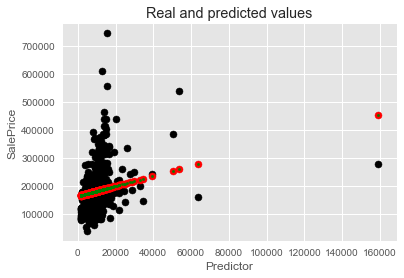

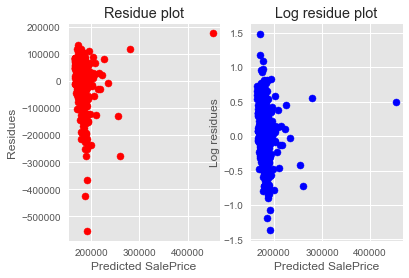

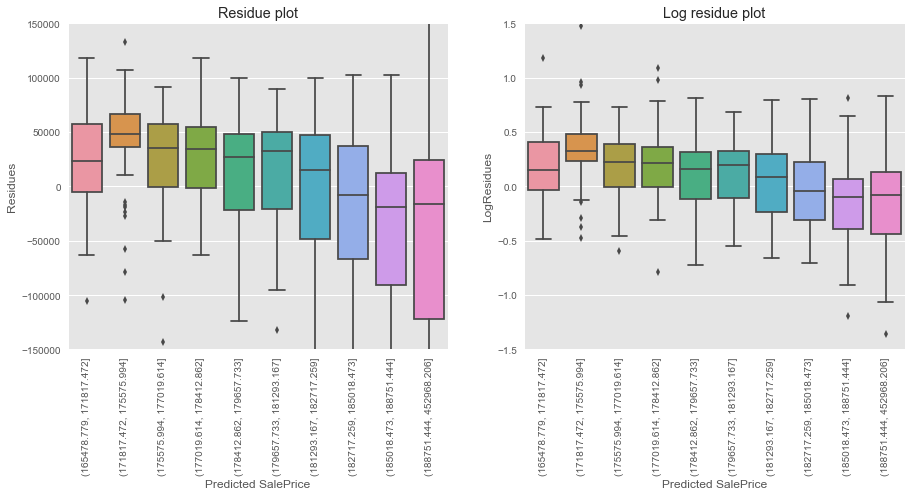

In [7]:
Y_test_predicted = linreg.predict(X_test)

model_results = pd.DataFrame(data = [[linreg.residues_,\
                                    calc_rmse(linreg.residues_, len(X_train)), \
                                    calc_rmse_by_hand(Y_train_predicted,Y_train, X_train),\
                                    calc_avg_deviation(Y_train_predicted, Y_train),\
                                    calc_max_deviation(Y_train_predicted, Y_train),\
                                    calc_logrmse_by_hand(Y_train_predicted,Y_train, X_train),\
                                    linreg.score(X_train,Y_train),\
                                    calc_r_sq_by_hand(Y_train_predicted, Y_train)\
                                    ],\
                                    []], \
                    index = [['LotArea (Univ.)', 'LotArea (Univ.)'],\
                                      ['Train', 'Valid.']],\
                    columns = ['Residues', 'RMSE', 'RMSE b.h.', 'avg. dev.', 'max dev.', 'LOGRMSE b.h.', 'R^2', 'R^2 b.h.'])
model_results.index.names = ['Model', 'Data type']

model_results.loc[('LotArea (Univ.)','Valid.'),:] = \
                    [np.nan,\
                    np.nan,\
                    calc_rmse_by_hand(Y_test_predicted, Y_test, X_test),\
                    calc_avg_deviation(Y_test_predicted, Y_test),\
                    calc_max_deviation(Y_test_predicted, Y_test),\
                    calc_logrmse_by_hand(Y_test_predicted, Y_test, X_test),\
                    np.nan,\
                    calc_r_sq_by_hand(Y_test_predicted, Y_test)]

display(model_results)

print(calc_adj_r_sq_by_hand(Y_test_predicted, Y_test, X_test.shape[1]))


# visualize y, y_hat and the draw regression line from the validation set
plot_real_and_predicted_values(X_test,Y_test,Y_test_predicted,linreg.intercept_,linreg.coef_)
# visualize residues and log residues vs. y_hat
plot_residues(Y_test_predicted,Y_test, X_test )

plot_residues_boxed(Y_test_predicted,Y_test, X_test )

In [8]:
# take the real test data for submission! 1459 rows!
# index of output file must be 1461 to 2919
Y_test_predicted = linreg.predict(df_test['LotArea'].values.reshape(len(df_test),1))
makeOutputFile(pd.DataFrame(data = Y_test_predicted, columns=['SalePrice'], index = range(1461,2920,1)), \
                'SalePrice', \
                 1
               )




 **************** Output written to: 'My_submission_1.csv' 



# 2. The target variable

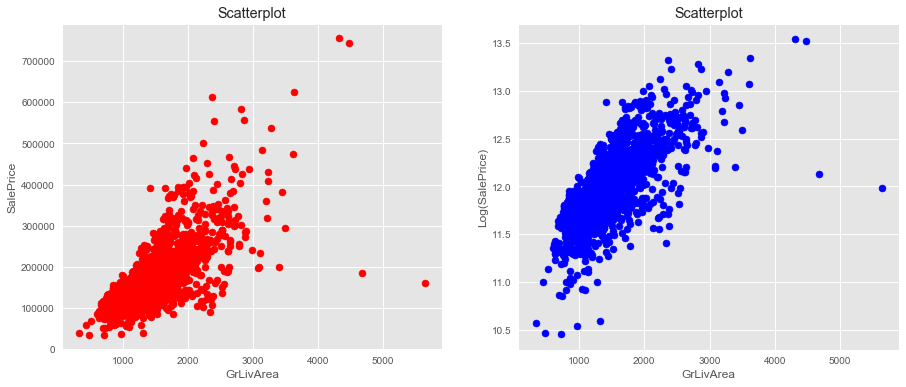

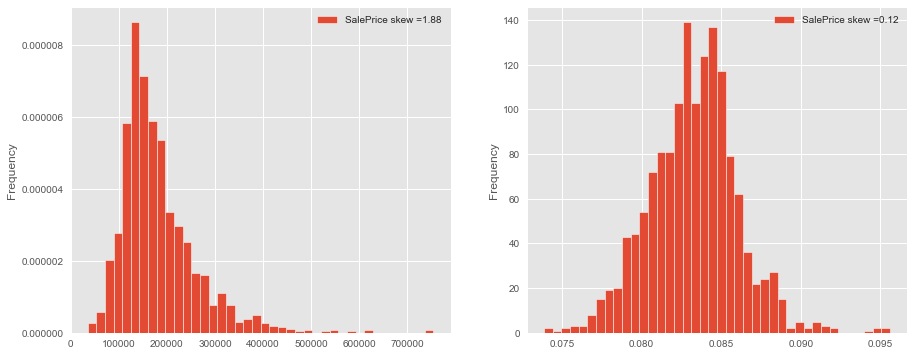

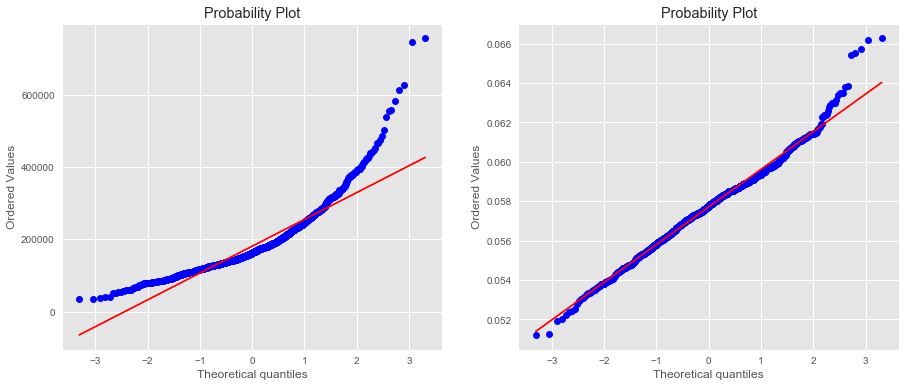

'\nplt.suptitle("SalePrice distribution")\nplt.legend()\nplt.show()\n'

In [9]:
"""
Quantil:
    Wir geben einen Anteil p vor, und fragen bei welcher Merkmalsausprägung X = x die kum. Häufigkeit
    diesen Anteil erreicht. Sprich "das null komma zwei fünf quantil" ( p = 0.25= F(X = x_p)).
    Bei geordneten Datensätzen der größe n sind die Beobachtungswerte x_i genau die  "p_i = i/n"-Quantile
    (i = geordnete Nummerierung der Beobachtungen)
    
QQ-plot:
    Zum Vergleich zweier empirischer Verteilungen oder einer emp. mit einer theor. Warum geht bei Vgl. mit norm. Vert.
    die X-Achse von ~ -2-3 bis ~ 2-3 ? Weil die p-Quantile der empirischen Daten (z.B. 0.25-Quantil) der std. norm. Vert.
    eben bei diesen Werten liet.

Skewness:
    3rd-moment of "X standardized by sigma" E[(X-mu/sigma)^2]. > means right-skewness

"""


fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(121)

ax2 = fig.add_subplot(122)

ax1.scatter(df_train.GrLivArea,df_train.SalePrice, color='red')

ax2.scatter(df_train.GrLivArea,df_train.SalePrice.apply(lambda x:  np.log(x)), color='blue')

ax1.set_title('Scatterplot')

ax1.set_ylabel('SalePrice')

ax1.set_xlabel('GrLivArea')

ax2.set_title('Scatterplot')

ax2.set_ylabel('Log(SalePrice)')

ax2.set_xlabel('GrLivArea')

plt.show()


skewness = df_train['SalePrice'].skew()

skewness_log = df_train['SalePrice'].apply(lambda x:  np.log(x)).skew()


fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(121)

ax2 = fig.add_subplot(122)

df_train['SalePrice'].plot.hist(edgecolor='white', bins=40, 
                                legend = True, label='SalePrice skew =' + str(round(skewness,2)), ax = ax1, normed = True)

df_train['SalePrice'].apply(lambda x:  1/np.log(x)).plot.hist(edgecolor='white', bins=40, 
                                legend = True, label='SalePrice skew =' + str(round(skewness_log,2)), ax = ax2)

plt.show()


fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(121)

ax1.set_title('QQ plot')
   
ax1.set_xlabel('Real SalePrice quantiles')

ax1.set_ylabel('Theor. quantiles')

theoretical_quantiles = qqplot(df_train['SalePrice'], plot = plt, dist = 'norm')

ax2 = fig.add_subplot(122)

ax2.set_title('QQ plot')
   
ax2.set_xlabel('Real log(SalePrice) quantiles')

ax2.set_ylabel('Theor. quantiles')

theoretical_quantiles = qqplot(df_train['SalePrice'].apply(lambda x:  1/np.log2(x)), plot = plt,dist = 'norm')

plt.show()


"""
plt.suptitle("SalePrice distribution")
plt.legend()
plt.show()
"""


# 3. Model with log(SalePrice) and LotArea

Residues        RMSE   RMSE b.h.  \
Model            Data type                                               
LotArea (Univ.)  Train      [5.2150660364e+12] 77157.44767 77157.44767   
                 Valid.                    NaN         nan 75901.74994   
Log SP + LotArea Valid.                    NaN         nan     0.37370   

                            avg. dev.     max dev.  LOGRMSE b.h.     R^2  \
Model            Data type                                                 
LotArea (Univ.)  Train       -0.00000 552913.23085       0.39830 0.06294   
                 Valid.    2641.95835 553702.96683       0.38204     nan   
Log SP + LotArea Valid.       0.01128      1.44696       0.03099     nan   

                            R^2 b.h.  
Model            Data type            
LotArea (Univ.)  Train       0.06294  
                 Valid.      0.07523  
Log SP + LotArea Valid.      0.07525

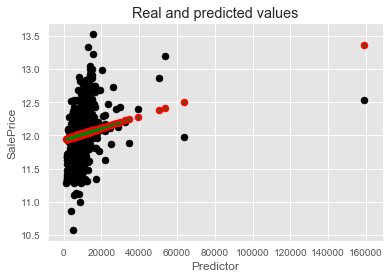

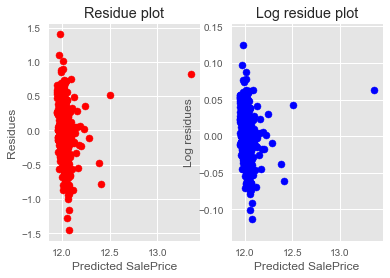

In [10]:
"""
1: 
    Every random variable X(predictor_i) has its own median and variance
    (scattering along y at x=const). 
2:
    Residue analysis (Residue level (2.2) and residue variance (2.1) are important)

2.1:
    Change of Variance:
    Heteroskedaszitität: V(Y(X_i)) increases with increasing i.
    Thus, the residues shall not posses a increasing variance.
    Leads to bad predictions for small X_i because model is optimized for large.
2.2:
    Change of mean:
    In a good (linear) model/underlying linear relationshiop,
    the residus are = the noise U(X_i). But E(U(X_i)) = 0, thus
    the residues shall not posses systematic shift in position from 0! -> check residue plot
    \/ shaped residue plots may indicate a quadratic relationship.
3:
    Right skewness: tail to the right.
    Compared to normal: the area under the distribution needs a feature intervall
    with larger values for the right end of the intervall
3.1:
    Ladder of transformations: take X -> ln(Y). stretches small values to a wider scale of Y and 
    compresses large values to a smaller scale of Y
"""

# create train/test data from the competition train data.
X_train,X_test,Y_train,Y_test = train_test_split (df_train['LotArea'], \
                                df_train['SalePrice'].apply(lambda x:  np.log(x)), \
                                test_size=0.4, random_state=0
                                )

# reshape all dataframes to dim(x,1) instead of (x,)
X_train,X_test,Y_train,Y_test = map(lambda x: x.values.reshape(len(x),1),[X_train,X_test,Y_train,Y_test])

linreg=LinearRegression()

# fit the model to the train split of the training data
# view parameters
linreg.fit(X_train,Y_train)

# predict the target on the test split of the training data
# view parameters
Y_test_predicted = linreg.predict(X_test)

model_results.loc[('Log SP + LotArea','Valid.'),:] = \
                    [np.nan,\
                    np.nan,\
                    calc_rmse_by_hand(Y_test_predicted, Y_test, X_test),\
                    calc_avg_deviation(Y_test_predicted, Y_test),\
                    calc_max_deviation(Y_test_predicted, Y_test),\
                    calc_logrmse_by_hand(Y_test_predicted, Y_test, X_test),\
                    np.nan,\
                    calc_r_sq_by_hand(Y_test_predicted, Y_test)]

display(model_results)
    
# visualize the residues and the predicted target
plot_real_and_predicted_values(X_test,Y_test,Y_test_predicted,linreg.intercept_,linreg.coef_)
# visualize residues and log residues vs. the predicted SalePrice
plot_residues(Y_test_predicted,Y_test, X_test )

# 3.1 Reverse the log transformation

Residues        RMSE   RMSE b.h.  \
Model            Data type                                               
LotArea (Univ.)  Train      [5.2150660364e+12] 77157.44767 77157.44767   
                 Valid.                    NaN         nan 75901.74994   
Log SP + LotArea Valid.                    NaN         nan     0.37370   
                 V.Retr.                   NaN         nan 78244.07036   

                              avg. dev.     max dev.  LOGRMSE b.h.     R^2  \
Model            Data type                                                   
LotArea (Univ.)  Train         -0.00000 552913.23085       0.39830 0.06294   
                 Valid.      2641.95835 553702.96683       0.38204     nan   
Log SP + LotArea Valid.         0.01128      1.44696       0.03099     nan   
                 V.Retr.   -11134.86260 569713.81407       0.37370     nan   

                            R^2 b.h.  
Model            Data type            
LotArea (Univ.)  Train       0.06294  
                 Valid.      0.07523  
Log SP + LotArea Valid.      0.07525  
                 V.Retr.     0.01727

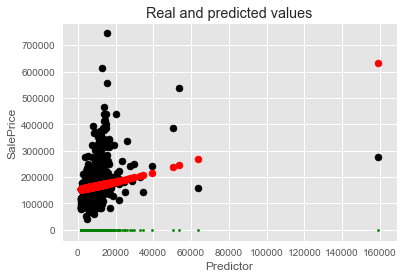

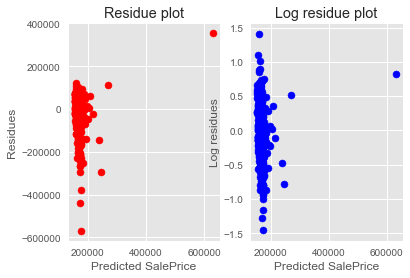

In [11]:
# reverse the log transform
Y_test = np.apply_along_axis(lambda x: np.exp(x), 1,Y_test)
Y_test_predicted = np.apply_along_axis(lambda x: np.exp(x), 1,Y_test_predicted)

model_results.loc[('Log SP + LotArea','V.Retr.'),:] = \
                    [np.nan,\
                    np.nan,\
                    calc_rmse_by_hand(Y_test_predicted, Y_test, X_test),\
                    calc_avg_deviation(Y_test_predicted, Y_test),\
                    calc_max_deviation(Y_test_predicted, Y_test),\
                    calc_logrmse_by_hand(Y_test_predicted, Y_test, X_test),\
                    np.nan,\
                    calc_r_sq_by_hand(Y_test_predicted, Y_test)]

display(model_results)

plot_real_and_predicted_values(X_test,Y_test,Y_test_predicted,linreg.intercept_,linreg.coef_)
# visualize residues and log residues vs. the predicted SalePrice
plot_residues(Y_test_predicted,Y_test, X_test )

In [12]:
# take the real test data for submission! 1459 rows!
# index of output file must be 1461 to 2919
Y_test_predicted = linreg.predict(df_test['LotArea'].values.reshape(len(df_test),1))
Y_test_predicted = np.apply_along_axis(lambda x: np.exp(x), 1,Y_test_predicted)
makeOutputFile(pd.DataFrame(data = Y_test_predicted, columns=['SalePrice'], index = range(1461,2920,1)), \
                'SalePrice' ,\
               2
                )


 **************** Output written to: 'My_submission_2.csv' 



# 4. Trying to find better independent variables for prediction

In [13]:
df_train_copy = df_train.copy()

df_train_copy['LogSalePrice'] = df_train['SalePrice'].apply(lambda x:  np.log(x))

correlDataFrame=df_train_copy.corr(method='pearson')# altern. try spearman (rank. corr.coeff.)

print(correlDataFrame[['LogSalePrice','SalePrice']].sort_values(by = 'SalePrice', ascending=False))

               LogSalePrice  SalePrice
SalePrice           0.94837    1.00000
LogSalePrice        1.00000    0.94837
OverallQual         0.81718    0.79098
GrLivArea           0.70093    0.70862
GarageCars          0.68062    0.64041
GarageArea          0.65089    0.62343
TotalBsmtSF         0.61213    0.61358
1stFlrSF            0.59698    0.60585
FullBath            0.59477    0.56066
TotRmsAbvGrd        0.53442    0.53372
YearBuilt           0.58657    0.52290
YearRemodAdd        0.56561    0.50710
GarageYrBlt         0.54107    0.48636
MasVnrArea          0.43081    0.47749
Fireplaces          0.48945    0.46693
BsmtFinSF1          0.37202    0.38642
LotFrontage         0.35588    0.35180
WoodDeckSF          0.33414    0.32441
2ndFlrSF            0.31930    0.31933
OpenPorchSF         0.32105    0.31586
HalfBath            0.31398    0.28411
LotArea             0.25732    0.26384
BsmtFullBath        0.23622    0.22712
BsmtUnfSF           0.22199    0.21448
BedroomAbvGr        0.209

# 4.1 Heatmap plots

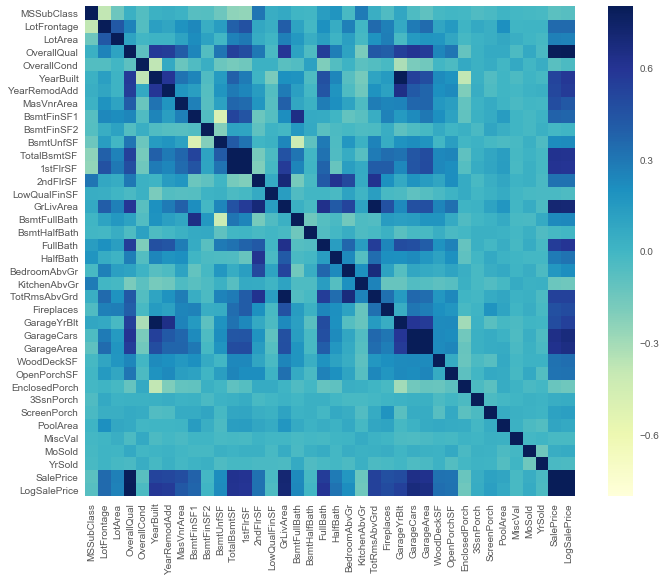

In [14]:
f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(correlDataFrame, vmax=.8, square=True, cmap="YlGnBu")

plt.show()

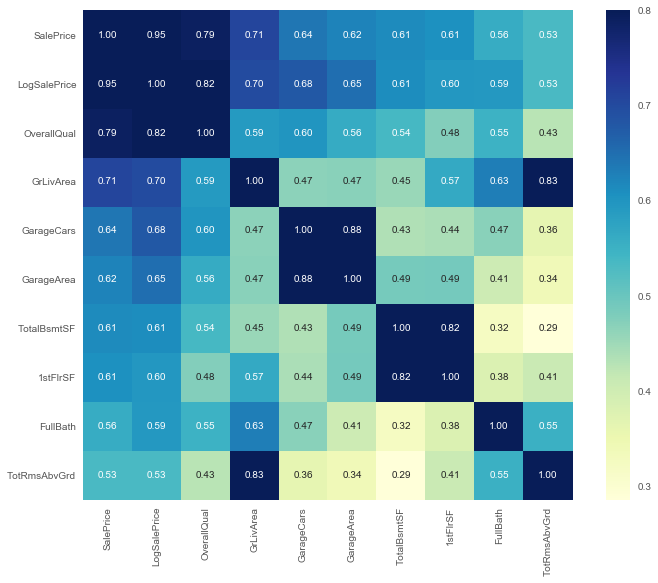

In [15]:
#list(correlDataFrame.SalePrice.sort_values(ascending=False))[]
mostCorrelFeatures = list(correlDataFrame.sort_values('SalePrice', ascending = False).index)[:10]

correlDataFrameWithHighCorrel = correlDataFrame.loc[mostCorrelFeatures][mostCorrelFeatures]

f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(correlDataFrameWithHighCorrel, vmax = .8, square = True,fmt='.2f', annot = True, cmap = "YlGnBu")

plt.show()
#annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values

# 4.2 Visualization of the dependencies of SalePrice on some selected Variables

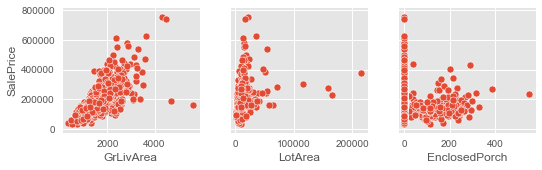

In [16]:
feature_list=['GrLivArea','LotArea','EnclosedPorch']#Variables for the 3 pair plots

pp = sns.pairplot(data=df_train, #sns pairplots
                  y_vars=['SalePrice'],
                  x_vars=feature_list)
plt.show()

# 5. Prediction based on the selection of GrLivArea as a more suitable predictor

Residues        RMSE   RMSE b.h.  \
Model              Data type                                               
LotArea (Univ.)    Train      [5.2150660364e+12] 77157.44767 77157.44767   
                   Valid.                    NaN         nan 75901.74994   
Log SP + LotArea   Valid.                    NaN         nan     0.37370   
                   V.Retr.                   NaN         nan 78244.07036   
Log SP + GrLivArea Valid.                    NaN         nan     0.28586   

                                avg. dev.     max dev.  LOGRMSE b.h.     R^2  \
Model              Data type                                                   
LotArea (Univ.)    Train         -0.00000 552913.23085       0.39830 0.06294   
                   Valid.      2641.95835 553702.96683       0.38204     nan   
Log SP + LotArea   Valid.         0.01128      1.44696       0.03099     nan   
                   V.Retr.   -11134.86260 569713.81407       0.37370     nan   
Log SP + GrLivArea Valid.         0.00089      2.33121       0.02351     nan   

                              R^2 b.h.  
Model              Data type            
LotArea (Univ.)    Train       0.06294  
                   Valid.      0.07523  
Log SP + LotArea   Valid.      0.07525  
                   V.Retr.     0.01727  
Log SP + GrLivArea Valid.      0.45889

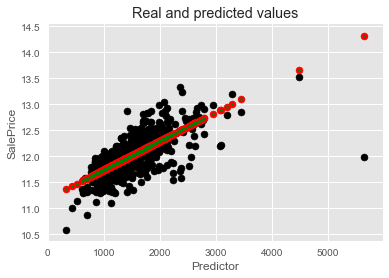

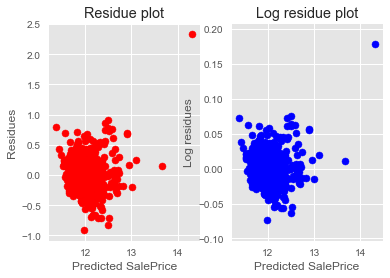

In [17]:
X_train,X_test,Y_train,Y_test = train_test_split (df_train['GrLivArea'], \
                                df_train['SalePrice'].apply(lambda x:  np.log(x)), \
                                test_size=0.4, random_state=0
                                )

X_train,X_test,Y_train,Y_test = map(lambda x: x.values.reshape(len(x),1),[X_train,X_test,Y_train,Y_test])

linreg=LinearRegression()

# fit the model to the train split of the training data
# view parameters
linreg.fit(X_train,Y_train)

# predict the target on the test split of the training data
# view parameters
Y_test_predicted = linreg.predict(X_test)

model_results.loc[('Log SP + GrLivArea','Valid.'),:] = \
                    [np.nan,\
                    np.nan,\
                    calc_rmse_by_hand(Y_test_predicted, Y_test, X_test),\
                    calc_avg_deviation(Y_test_predicted, Y_test),\
                    calc_max_deviation(Y_test_predicted, Y_test),\
                    calc_logrmse_by_hand(Y_test_predicted, Y_test, X_test),\
                    np.nan,\
                    calc_r_sq_by_hand(Y_test_predicted, Y_test)]

display(model_results)
    
# visualize the residues and the predicted target
plot_real_and_predicted_values(X_test,Y_test,Y_test_predicted,linreg.intercept_,linreg.coef_)
# visualize residues and log residues vs. the predicted SalePrice
plot_residues(Y_test_predicted,Y_test, X_test )

# 5.1. Reverse the log transformation

Residues        RMSE   RMSE b.h.  \
Model              Data type                                               
LotArea (Univ.)    Train      [5.2150660364e+12] 77157.44767 77157.44767   
                   Valid.                    NaN         nan 75901.74994   
Log SP + LotArea   Valid.                    NaN         nan     0.37370   
                   V.Retr.                   NaN         nan 78244.07036   
Log SP + GrLivArea Valid.                    NaN         nan     0.28586   
                   V.Retr.                   NaN         nan 82781.73182   

                                avg. dev.      max dev.  LOGRMSE b.h.     R^2  \
Model              Data type                                                    
LotArea (Univ.)    Train         -0.00000  552913.23085       0.39830 0.06294   
                   Valid.      2641.95835  553702.96683       0.38204     nan   
Log SP + LotArea   Valid.         0.01128       1.44696       0.03099     nan   
                   V.Retr.   -11134.86260  569713.81407       0.37370     nan   
Log SP + GrLivArea Valid.         0.00089       2.33121       0.02351     nan   
                   V.Retr.    -4352.27084 1486468.23047       0.28586     nan   

                              R^2 b.h.  
Model              Data type            
LotArea (Univ.)    Train       0.06294  
                   Valid.      0.07523  
Log SP + LotArea   Valid.      0.07525  
                   V.Retr.     0.01727  
Log SP + GrLivArea Valid.      0.45889  
                   V.Retr.    -0.10002

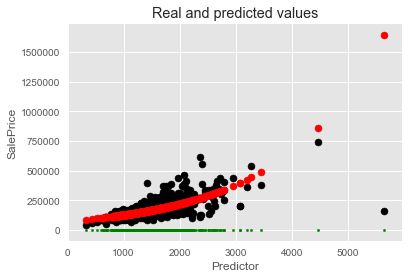

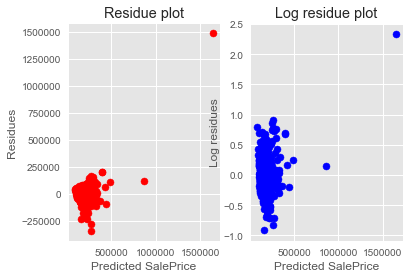

In [18]:
Y_test = np.apply_along_axis(lambda x: np.exp(x), 1,Y_test)
Y_test_predicted = np.apply_along_axis(lambda x: np.exp(x), 1,Y_test_predicted)

model_results.loc[('Log SP + GrLivArea','V.Retr.'),:] = \
                    [np.nan,\
                    np.nan,\
                    calc_rmse_by_hand(Y_test_predicted, Y_test, X_test),\
                    calc_avg_deviation(Y_test_predicted, Y_test),\
                    calc_max_deviation(Y_test_predicted, Y_test),\
                    calc_logrmse_by_hand(Y_test_predicted, Y_test, X_test),\
                    np.nan,\
                    calc_r_sq_by_hand(Y_test_predicted, Y_test)]

display(model_results)    
    
plot_real_and_predicted_values(X_test,Y_test,Y_test_predicted,linreg.intercept_,linreg.coef_)
# visualize residues and log residues vs. the predicted SalePrice
plot_residues(Y_test_predicted,Y_test, X_test )

In [19]:
# take the real test data for submission! 1459 rows!
# index of output file must be 1461 to 2919
Y_test_predicted = linreg.predict(df_test['GrLivArea'].values.reshape(len(df_test),1))
Y_test_predicted = np.apply_along_axis(lambda x: np.exp(x), 1,Y_test_predicted)
makeOutputFile(pd.DataFrame(data = Y_test_predicted, columns=['SalePrice'], index = range(1461,2920,1)), \
                'SalePrice' ,\
               3
                )


 **************** Output written to: 'My_submission_3.csv' 



# 5.2 Removing outliers

In [20]:
display(df_train.sort_values('GrLivArea')[['SalePrice','GrLivArea']].tail(7))

display(df_test.sort_values('GrLivArea')[['GrLivArea']].tail(7))

,SalePrice,GrLivArea
Id,,
305,295000,3493
186,475000,3608
1170,625000,3627
692,755000,4316
1183,745000,4476
524,184750,4676
1299,160000,5642


,GrLivArea
Id,
2332,3078
2425,3086
2629,3390
2683,3500
2823,3672
2189,3820
2550,5095


In [21]:
df_train_copy = df_train.copy()

df_train_copy = df_train_copy.drop([692,1183,524,1299])# drops exact indices

df_train_copy = df_train_copy.reset_index(drop = True) # close gaps in index

df_train_copy.index = df_train_copy.index+1 # start like the original index

display(df_train_copy.head(2))

display(df_train_copy.tail(2))


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65.00000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.00000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.00000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.00000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,20,RL,68.00000,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.00000,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.00000,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1456,20,RL,75.00000,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,1965,1965,Gable,CompShg,HdBoard,HdBoard,None,0.00000,Gd,TA,CBlock,TA,TA,No,BLQ,830,LwQ,290,136,1256,GasA,Gd,Y,SBrkr,1256,0,0,1256,1,0,1,1,3,1,TA,6,Typ,0,NaN,Attchd,1965.00000,Fin,1,276,TA,TA,Y,736,68,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


# 5.3 Re-model with GrLivArea with dropped outliers

Residues        RMSE  \
Model              Data type                                             
LotArea (Univ.)    Train                [5.2150660364e+12] 77157.44767   
                   Valid.                              NaN         nan   
Log SP + LotArea   Valid.                              NaN         nan   
                   V.Retr.                             NaN         nan   
Log SP + GrLivArea Valid.                              NaN         nan   
                   V.Retr.                             NaN         nan   
                   Valid. w/o Outliers                 NaN         nan   

                                         RMSE b.h.    avg. dev.      max dev.  \
Model              Data type                                                    
LotArea (Univ.)    Train               77157.44767     -0.00000  552913.23085   
                   Valid.              75901.74994   2641.95835  553702.96683   
Log SP + LotArea   Valid.                  0.37370      0.01128       1.44696   
                   V.Retr.             78244.07036 -11134.86260  569713.81407   
Log SP + GrLivArea Valid.                  0.28586      0.00089       2.33121   
                   V.Retr.             82781.73182  -4352.27084 1486468.23047   
                   Valid. w/o Outliers     0.27434     -0.01636       1.16799   

                                        LOGRMSE b.h.     R^2  R^2 b.h.  
Model              Data type                                            
LotArea (Univ.)    Train                     0.39830 0.06294   0.06294  
                   Valid.                    0.38204     nan   0.07523  
Log SP + LotArea   Valid.                    0.03099     nan   0.07525  
                   V.Retr.                   0.37370     nan   0.01727  
Log SP + GrLivArea Valid.                    0.02351     nan   0.45889  
                   V.Retr.                   0.28586     nan  -0.10002  
                   Valid. w/o Outliers       0.02281     nan   0.53511

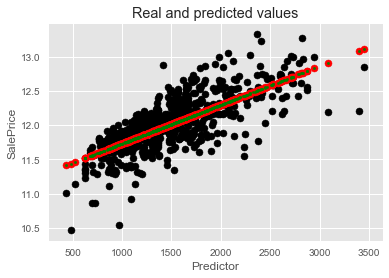

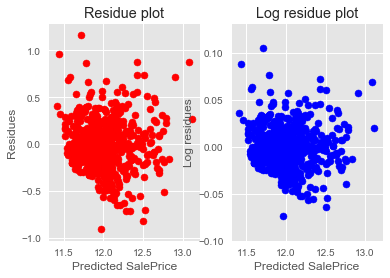

In [22]:
X_train,X_test,Y_train,Y_test = train_test_split (df_train_copy['GrLivArea'], \
                                df_train_copy['SalePrice'].apply(lambda x:  np.log(x)), \
                                test_size=0.4, random_state=0
                                )

X_train,X_test,Y_train,Y_test = map(lambda x: x.values.reshape(len(x),1),[X_train,X_test,Y_train,Y_test])

linreg=LinearRegression()

# fit the model to the train split of the training data
# view parameters
linreg.fit(X_train,Y_train)

# predict the target on the test split of the training data
# view parameters
Y_test_predicted = linreg.predict(X_test)

model_results.loc[('Log SP + GrLivArea','Valid. w/o Outliers'),:] = \
                    [np.nan,\
                    np.nan,\
                    calc_rmse_by_hand(Y_test_predicted, Y_test, X_test),\
                    calc_avg_deviation(Y_test_predicted, Y_test),\
                    calc_max_deviation(Y_test_predicted, Y_test),\
                    calc_logrmse_by_hand(Y_test_predicted, Y_test, X_test),\
                    np.nan,\
                    calc_r_sq_by_hand(Y_test_predicted, Y_test)]

display(model_results)
    
# visualize the residues and the predicted target
plot_real_and_predicted_values(X_test,Y_test,Y_test_predicted,linreg.intercept_,linreg.coef_)
# visualize residues and log residues vs. the predicted SalePrice
plot_residues(Y_test_predicted,Y_test, X_test )

Residues        RMSE  \
Model              Data type                                                   
LotArea (Univ.)    Train                      [5.2150660364e+12] 77157.44767   
                   Valid.                                    NaN         nan   
Log SP + LotArea   Valid.                                    NaN         nan   
                   V.Retr.                                   NaN         nan   
Log SP + GrLivArea Valid.                                    NaN         nan   
                   V.Retr.                                   NaN         nan   
                   Valid. w/o Outliers                       NaN         nan   
                   Valid. w/o Outliers Retr.                 NaN         nan   

                                               RMSE b.h.    avg. dev.  \
Model              Data type                                            
LotArea (Univ.)    Train                     77157.44767     -0.00000   
                   Valid.                    75901.74994   2641.95835   
Log SP + LotArea   Valid.                        0.37370      0.01128   
                   V.Retr.                   78244.07036 -11134.86260   
Log SP + GrLivArea Valid.                        0.28586      0.00089   
                   V.Retr.                   82781.73182  -4352.27084   
                   Valid. w/o Outliers           0.27434     -0.01636   
                   Valid. w/o Outliers Retr. 57515.04964  -9744.07247   

                                                  max dev.  LOGRMSE b.h.  \
Model              Data type                                               
LotArea (Univ.)    Train                      552913.23085       0.39830   
                   Valid.                     553702.96683       0.38204   
Log SP + LotArea   Valid.                          1.44696       0.03099   
                   V.Retr.                    569713.81407       0.37370   
Log SP + GrLivArea Valid.                          2.33121       0.02351   
                   V.Retr.                   1486468.23047       0.28586   
                   Valid. w/o Outliers             1.16799       0.02281   
                   Valid. w/o Outliers Retr.  343165.28216       0.27434   

                                                 R^2  R^2 b.h.  
Model              Data type                                    
LotArea (Univ.)    Train                     0.06294   0.06294  
                   Valid.                        nan   0.07523  
Log SP + LotArea   Valid.                        nan   0.07525  
                   V.Retr.                       nan   0.01727  
Log SP + GrLivArea Valid.                        nan   0.45889  
                   V.Retr.                       nan  -0.10002  
                   Valid. w/o Outliers           nan   0.53511  
                   Valid. w/o Outliers Retr.     nan   0.47211

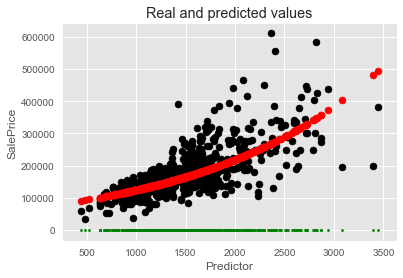

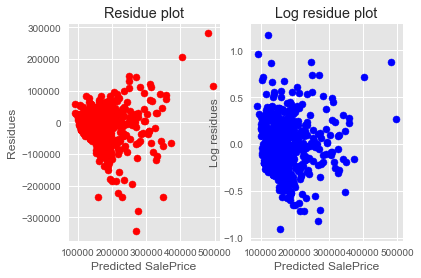

In [23]:
Y_test = np.apply_along_axis(lambda x: np.exp(x), 1,Y_test)
Y_test_predicted = np.apply_along_axis(lambda x: np.exp(x), 1,Y_test_predicted)

model_results.loc[('Log SP + GrLivArea','Valid. w/o Outliers Retr.'),:] = \
                    [np.nan,\
                    np.nan,\
                    calc_rmse_by_hand(Y_test_predicted, Y_test, X_test),\
                    calc_avg_deviation(Y_test_predicted, Y_test),\
                    calc_max_deviation(Y_test_predicted, Y_test),\
                    calc_logrmse_by_hand(Y_test_predicted, Y_test, X_test),\
                    np.nan,\
                    calc_r_sq_by_hand(Y_test_predicted, Y_test)]

display(model_results)    
    
plot_real_and_predicted_values(X_test,Y_test,Y_test_predicted,linreg.intercept_,linreg.coef_)
# visualize residues and log residues vs. the predicted SalePrice
plot_residues(Y_test_predicted,Y_test, X_test )

# 6 Multiple predictors: adding garage area

Residues  \
Model                           Data type                                       
LotArea (Univ.)                 Train                      [5.2150660364e+12]   
                                Valid.                                    NaN   
Log SP + LotArea                Valid.                                    NaN   
                                V.Retr.                                   NaN   
Log SP + GrLivArea              Valid.                                    NaN   
                                V.Retr.                                   NaN   
                                Valid. w/o Outliers                       NaN   
                                Valid. w/o Outliers Retr.                 NaN   
Log SP + GrLivArea + GarageArea Valid. w/o outliers                       NaN   

                                                                 RMSE  \
Model                           Data type                               
LotArea (Univ.)                 Train                     77157.44767   
                                Valid.                            nan   
Log SP + LotArea                Valid.                            nan   
                                V.Retr.                           nan   
Log SP + GrLivArea              Valid.                            nan   
                                V.Retr.                           nan   
                                Valid. w/o Outliers               nan   
                                Valid. w/o Outliers Retr.         nan   
Log SP + GrLivArea + GarageArea Valid. w/o outliers               nan   

                                                            RMSE b.h.  \
Model                           Data type                               
LotArea (Univ.)                 Train                     77157.44767   
                                Valid.                    75901.74994   
Log SP + LotArea                Valid.                        0.37370   
                                V.Retr.                   78244.07036   
Log SP + GrLivArea              Valid.                        0.28586   
                                V.Retr.                   82781.73182   
                                Valid. w/o Outliers           0.27434   
                                Valid. w/o Outliers Retr. 57515.04964   
Log SP + GrLivArea + GarageArea Valid. w/o outliers           0.23533   

                                                             avg. dev.  \
Model                           Data type                                
LotArea (Univ.)                 Train                         -0.00000   
                                Valid.                      2641.95835   
Log SP + LotArea                Valid.                         0.01128   
                                V.Retr.                   -11134.86260   
Log SP + GrLivArea              Valid.                         0.00089   
                                V.Retr.                    -4352.27084   
                                Valid. w/o Outliers           -0.01636   
                                Valid. w/o Outliers Retr.  -9744.07247   
Log SP + GrLivArea + GarageArea Valid. w/o outliers           -0.00207   

                                                               max dev.  \
Model                           Data type                                 
LotArea (Univ.)                 Train                      552913.23085   
                                Valid.                     553702.96683   
Log SP + LotArea                Valid.                          1.44696   
                                V.Retr.                    569713.81407   
Log SP + GrLivArea              Valid.                          2.33121   
                                V.Retr.                   1486468.23047   
                                Valid. w/o Outliers             1.16799   
                                Valid. w/o Outliers Retr.  343165.28216   
Log 

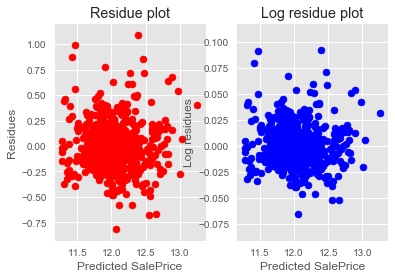

In [24]:
X_train,X_test,Y_train,Y_test = train_test_split (df_train_copy[['GarageArea','GrLivArea']], \
                                df_train_copy['SalePrice'].apply(lambda x:  np.log(x)), \
                                test_size=0.4, random_state=0
                              )

Y_train,Y_test = map(lambda x: x.values.reshape(len(x),1),[Y_train,Y_test])

linreg=LinearRegression()

## fit the model to the train split of the training data
# view parameters
linreg.fit(X_train,Y_train)

## predict the target on the test split of the training data
# view parameters
Y_test_predicted = linreg.predict(X_test)

model_results.loc[('Log SP + GrLivArea + GarageArea','Valid. w/o outliers'),:] = \
                    [np.nan,\
                    np.nan,\
                    calc_rmse_by_hand(Y_test_predicted, Y_test, X_test),\
                    calc_avg_deviation(Y_test_predicted, Y_test),\
                    calc_max_deviation(Y_test_predicted, Y_test),\
                    calc_logrmse_by_hand(Y_test_predicted, Y_test, X_test),\
                    np.nan,\
                    calc_r_sq_by_hand(Y_test_predicted, Y_test)]

display(model_results)
    
# visualize residues and log residues vs. the predicted SalePrice
plot_residues(Y_test_predicted,Y_test, X_test )


# 6.1 Multiple predictors: retrafo with garage area

In [25]:
## reverse the log transform and calculate statistics
Y_test = np.apply_along_axis(lambda x: np.exp(x), 1,Y_test)

Y_test_predicted = np.apply_along_axis(lambda x: np.exp(x), 1,Y_test_predicted)

model_results.loc[('Log SP + GrLivArea + GarageArea','Valid. w/o outliers retr.'),:] = \
                    [np.nan,\
                    np.nan,\
                    calc_rmse_by_hand(Y_test_predicted, Y_test, X_test),\
                    calc_avg_deviation(Y_test_predicted, Y_test),\
                    calc_max_deviation(Y_test_predicted, Y_test),\
                    calc_logrmse_by_hand(Y_test_predicted, Y_test, X_test),\
                    np.nan,\
                    calc_r_sq_by_hand(Y_test_predicted, Y_test)]

display(model_results)

Residues  \
Model                           Data type                                       
LotArea (Univ.)                 Train                      [5.2150660364e+12]   
                                Valid.                                    NaN   
Log SP + LotArea                Valid.                                    NaN   
                                V.Retr.                                   NaN   
Log SP + GrLivArea              Valid.                                    NaN   
                                V.Retr.                                   NaN   
                                Valid. w/o Outliers                       NaN   
                                Valid. w/o Outliers Retr.                 NaN   
Log SP + GrLivArea + GarageArea Valid. w/o outliers                       NaN   
                                Valid. w/o outliers retr.                 NaN   

                                                                 RMSE  \
Model                           Data type                               
LotArea (Univ.)                 Train                     77157.44767   
                                Valid.                            nan   
Log SP + LotArea                Valid.                            nan   
                                V.Retr.                           nan   
Log SP + GrLivArea              Valid.                            nan   
                                V.Retr.                           nan   
                                Valid. w/o Outliers               nan   
                                Valid. w/o Outliers Retr.         nan   
Log SP + GrLivArea + GarageArea Valid. w/o outliers               nan   
                                Valid. w/o outliers retr.         nan   

                                                            RMSE b.h.  \
Model                           Data type                               
LotArea (Univ.)                 Train                     77157.44767   
                                Valid.                    75901.74994   
Log SP + LotArea                Valid.                        0.37370   
                                V.Retr.                   78244.07036   
Log SP + GrLivArea              Valid.                        0.28586   
                                V.Retr.                   82781.73182   
                                Valid. w/o Outliers           0.27434   
                                Valid. w/o Outliers Retr. 57515.04964   
Log SP + GrLivArea + GarageArea Valid. w/o outliers           0.23533   
                                Valid. w/o outliers retr. 48487.75950   

                                                             avg. dev.  \
Model                           Data type                                
LotArea (Univ.)                 Train                         -0.00000   
                                Valid.                      2641.95835   
Log SP + LotArea                Valid.                         0.01128   
                                V.Retr.                   -11134.86260   
Log SP + GrLivArea              Valid.                         0.00089   
                                V.Retr.                    -4352.27084   
                                Valid. w/o Outliers           -0.01636   
                                Valid. w/o Outliers Retr.  -9744.07247   
Log SP + GrLivArea + GarageArea Valid. w/o outliers           -0.00207   
                                Valid. w/o outliers retr.  -5072.13689   

                                                               max dev.  \
Model                           Data type                                 
LotArea (Univ.)                 Train                      552913.23085   
                                Valid.                     553702.96683   
Log SP + LotArea                Valid.                          1.44696   
                                V.Retr.                    569713.81407   
Log

# 6.2 output

In [26]:
## Output file:take the real test data for submission! 1459 rows!
# index of output file must be 1461 to 2919
#
# prepare test data: select columns, fill missing GaraArea value by median
df_test_selected_rows = df_test[['GarageArea','GrLivArea']]

df_test_selected_rows['GarageArea'] = df_test_selected_rows['GarageArea']. \
    fillna(value = df_test_selected_rows['GarageArea'].median())

Y_test_predicted = linreg.predict(df_test_selected_rows)

Y_test_predicted = np.apply_along_axis(lambda x: np.exp(x), 1,Y_test_predicted)

makeOutputFile(pd.DataFrame( Y_test_predicted, columns=['SalePrice'],\
                index = range(1461,2920,1)), \
                'SalePrice' ,\
               5
                )


 **************** Output written to: 'My_submission_5.csv' 



# 7 Add categorical variable OverallQual

In [27]:
X_train,X_test,Y_train,Y_test = train_test_split (df_train_copy[['GarageArea','GrLivArea','OverallQual']], \
                                df_train_copy['SalePrice'].apply(lambda x:  np.log(x)), \
                                test_size=0.4, random_state=0
                              )

Y_train,Y_test = map(lambda x: x.values.reshape(len(x),1),[Y_train,Y_test])

linreg=LinearRegression()

linreg.fit(X_train,Y_train)

Y_test_predicted = linreg.predict(X_test)

## predict the target on the test split of the training data
# view parameters
model_results.loc[('Log SP + GrLivArea + GarageArea + OverallQual','Valid. w/o outliers'),:] = \
                    [np.nan,\
                    np.nan,\
                    calc_rmse_by_hand(Y_test_predicted, Y_test, X_test),\
                    calc_avg_deviation(Y_test_predicted, Y_test),\
                    calc_max_deviation(Y_test_predicted, Y_test),\
                    calc_logrmse_by_hand(Y_test_predicted, Y_test, X_test),\
                    np.nan,\
                    calc_r_sq_by_hand(Y_test_predicted, Y_test)]

display(model_results)

Residues  \
Model                                         Data type                                       
LotArea (Univ.)                               Train                      [5.2150660364e+12]   
                                              Valid.                                    NaN   
Log SP + LotArea                              Valid.                                    NaN   
                                              V.Retr.                                   NaN   
Log SP + GrLivArea                            Valid.                                    NaN   
                                              V.Retr.                                   NaN   
                                              Valid. w/o Outliers                       NaN   
                                              Valid. w/o Outliers Retr.                 NaN   
Log SP + GrLivArea + GarageArea               Valid. w/o outliers                       NaN   
                                              Valid. w/o outliers retr.                 NaN   
Log SP + GrLivArea + GarageArea + OverallQual Valid. w/o outliers                       NaN   

                                                                               RMSE  \
Model                                         Data type                               
LotArea (Univ.)                               Train                     77157.44767   
                                              Valid.                            nan   
Log SP + LotArea                              Valid.                            nan   
                                              V.Retr.                           nan   
Log SP + GrLivArea                            Valid.                            nan   
                                              V.Retr.                           nan   
                                              Valid. w/o Outliers               nan   
                                              Valid. w/o Outliers Retr.         nan   
Log SP + GrLivArea + GarageArea               Valid. w/o outliers               nan   
                                              Valid. w/o outliers retr.         nan   
Log SP + GrLivArea + GarageArea + OverallQual Valid. w/o outliers               nan   

                                                                          RMSE b.h.  \
Model                                         Data type                               
LotArea (Univ.)                               Train                     77157.44767   
                                              Valid.                    75901.74994   
Log SP + LotArea                              Valid.                        0.37370   
                                              V.Retr.                   78244.07036   
Log SP + GrLivArea                            Valid.                        0.28586   
                                              V.Retr.                   82781.73182   
                                              Valid. w/o Outliers           0.27434   
                                              Valid. w/o Outliers Retr. 57515.04964   
Log SP + GrLivArea + GarageArea               Valid. w/o outliers           0.23533   
                                              Valid. w/o outliers retr. 48487.75950   
Log SP + GrLivArea + GarageArea + OverallQual Valid. w/o outliers           0.17032   

                                                                           avg. dev.  \
Model                                         Data type                                
LotArea (Univ.)                               Train                         -0.00000   
                                              Valid.                      2641.95835   
Log SP + LotArea                              Valid.                         0.01128   
                                              V.Retr.                   -11134.86260   
Log SP + GrLivArea                            Valid.   

# 7.2 Reverse the log trafo

In [28]:
## reverse the log transform and calculate statistics
Y_test = np.apply_along_axis(lambda x: np.exp(x), 1,Y_test)

Y_test_predicted = np.apply_along_axis(lambda x: np.exp(x), 1,Y_test_predicted)

model_results.loc[('Log SP + GrLivArea + GarageArea + OverallQual','Valid. w/o outliers retr.'),:] = \
                    [np.nan,\
                    np.nan,\
                    calc_rmse_by_hand(Y_test_predicted, Y_test, X_test),\
                    calc_avg_deviation(Y_test_predicted, Y_test),\
                    calc_max_deviation(Y_test_predicted, Y_test),\
                    calc_logrmse_by_hand(Y_test_predicted, Y_test, X_test),\
                    np.nan,\
                    calc_r_sq_by_hand(Y_test_predicted, Y_test)]

display(model_results)

Residues  \
Model                                         Data type                                       
LotArea (Univ.)                               Train                      [5.2150660364e+12]   
                                              Valid.                                    NaN   
Log SP + LotArea                              Valid.                                    NaN   
                                              V.Retr.                                   NaN   
Log SP + GrLivArea                            Valid.                                    NaN   
                                              V.Retr.                                   NaN   
                                              Valid. w/o Outliers                       NaN   
                                              Valid. w/o Outliers Retr.                 NaN   
Log SP + GrLivArea + GarageArea               Valid. w/o outliers                       NaN   
                                              Valid. w/o outliers retr.                 NaN   
Log SP + GrLivArea + GarageArea + OverallQual Valid. w/o outliers                       NaN   
                                              Valid. w/o outliers retr.                 NaN   

                                                                               RMSE  \
Model                                         Data type                               
LotArea (Univ.)                               Train                     77157.44767   
                                              Valid.                            nan   
Log SP + LotArea                              Valid.                            nan   
                                              V.Retr.                           nan   
Log SP + GrLivArea                            Valid.                            nan   
                                              V.Retr.                           nan   
                                              Valid. w/o Outliers               nan   
                                              Valid. w/o Outliers Retr.         nan   
Log SP + GrLivArea + GarageArea               Valid. w/o outliers               nan   
                                              Valid. w/o outliers retr.         nan   
Log SP + GrLivArea + GarageArea + OverallQual Valid. w/o outliers               nan   
                                              Valid. w/o outliers retr.         nan   

                                                                          RMSE b.h.  \
Model                                         Data type                               
LotArea (Univ.)                               Train                     77157.44767   
                                              Valid.                    75901.74994   
Log SP + LotArea                              Valid.                        0.37370   
                                              V.Retr.                   78244.07036   
Log SP + GrLivArea                            Valid.                        0.28586   
                                              V.Retr.                   82781.73182   
                                              Valid. w/o Outliers           0.27434   
                                              Valid. w/o Outliers Retr. 57515.04964   
Log SP + GrLivArea + GarageArea               Valid. w/o outliers           0.23533   
                                              Valid. w/o outliers retr. 48487.75950   
Log SP + GrLivArea + GarageArea + OverallQual Valid. w/o outliers           0.17032   
                                              Valid. w/o outliers retr. 33258.02475   

                                                                           avg. dev.  \
Model                                         Data type                                
LotArea (Univ.)                               Train                         -0.00000   
                                              Vali

# 7.3 Output

In [29]:
## Output file:take the real test data for submission! 1459 rows!
# index of output file must be 1461 to 2919
#
# prepare test data: select columns, fill missing GaraArea value by median
df_test_selected_rows = df_test[['GarageArea','GrLivArea','OverallQual']]

df_test_selected_rows['GarageArea'] = df_test_selected_rows['GarageArea']. \
                            fillna(value = df_test_selected_rows['GarageArea'].median())

Y_test_predicted = linreg.predict(df_test_selected_rows)

Y_test_predicted = np.apply_along_axis(lambda x: np.exp(x), 1,Y_test_predicted)

makeOutputFile(pd.DataFrame( Y_test_predicted, columns=['SalePrice'], index = range(1461,2920,1)), \
                'SalePrice' ,\
               6
                )


 **************** Output written to: 'My_submission_6.csv' 



# Prediction with OverallQual and CV

In [30]:
X_train2 = X_train
Y_train2 = Y_train

def calc_rmse_logrmse_by_hand2(realSalesPrice,predictedSalesPrice):
    """
    Args:
    predictedSalesPrice (ndarray):
    realSalesPrice (ndarray):
    predictorObservations (ndarray):
    
    Returns:
    prints RMSE and LOGRMSE
    """
    #print(type(realSalesPrice), type(predictedSalesPrice))
    #print(realSalesPrice.shape, predictedSalesPrice.shape)
    #print(realSalesPrice, predictedSalesPrice)
    # put all args into a dataframs
    # calc residues and log residues by hand
    dferror = pd.DataFrame(predictedSalesPrice, np.arange(predictedSalesPrice.shape[0]), ['PredictedSalesPrice'])
    #dferror['PredictedSalesPrice'] = predictedSalesPrice
    dferror['SalePrice']=pd.Series(realSalesPrice.tolist(), index = np.arange(predictedSalesPrice.shape[0] ))
    print(dferror.head())
    dferror['Residues']=dferror.PredictedSalesPrice-dferror.SalePrice
    dferror['LogResidues']=(dferror.PredictedSalesPrice.apply(lambda x: np.log(x)))-\
                                    (dferror.SalePrice.apply(lambda x: np.log(x)))
    # square residues and sum em up
    squaredsumoferrors = dferror.Residues.apply(lambda x: x*x).sum()/dferror.shape[0]
    squaredsumoflogerrors = dferror.LogResidues.apply(lambda x: x*x).sum()
    
    #print ("RMSE by Hand:", calc_rmse(squaredsumoferrors, dferror.shape[0]))
    #print ("LOGRMSE by Hand:", calc_rmse(squaredsumoflogerrors, dferror.shape[0]))
    print(dferror.head())
    return squaredsumoferrors
#  sklearn.model_selection.cross_val_score(estimator, X, y=None,
#groups=None, scoring=None, cv=None, n_jobs=1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')[source]
#
# from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score and r2_score.
X_train = df_train_copy[['GarageArea','GrLivArea','OverallQual']].copy()

Y_train = df_train_copy['SalePrice'].apply(lambda x:  np.log(x)).copy()

# sklearn.metrics.make_scorer(score_func, greater_is_better=True, needs_proba=False,
# needs_threshold=False, **kwargs)[source]
rootmse = make_scorer(calc_rmse_logrmse_by_hand2,greater_is_better = False)
rootlogrmse = make_scorer(calc_rmse_logrmse_by_hand3,greater_is_better = False)  
linreg2=LinearRegression()
linreg2.fit(X_train2, Y_train2)



r2_scores = cross_val_score(linreg2, X_train, Y_train, scoring='r2')
x =cross_val_score(linreg2, X_train, Y_train, scoring='neg_mean_squared_error')
#np.apply_along_axis(lambda x: np.sqrt(x*(-1)), 0, x)
z = cross_val_score(linreg2, X_train, Y_train, scoring=rootmse)
w = cross_val_score(linreg2, X_train, Y_train, scoring=rootlogrmse)


print("Accuracy of R2-score: %0.4f (+/- %0.4f)" % (r2_scores.mean(), r2_scores.std() * 2))
print(r2_scores)
print("Accuracy of neg_mean_sqrt_e: %0.4f (+/- %0.4f)" % (x.mean(), x.std() * 2))
print(x)
print("Accuracy of own rmse func: %0.4f (+/- %0.4f)" % (z.mean(), z.std() * 2))
print(z)
print("Accuracy of own log rmse: %0.4f (+/- %0.4f)" % (w.mean(), w.std() * 2))
print(w)

   PredictedSalesPrice  SalePrice
0             12.23958   12.24769
1             11.94397   12.10901
2             12.28209   12.31717
3             12.27950   11.84940
4             12.62611   12.42922
   PredictedSalesPrice  SalePrice  Residues  LogResidues
0             12.23958   12.24769  -0.00811     -0.00066
1             11.94397   12.10901  -0.16504     -0.01372
2             12.28209   12.31717  -0.03508     -0.00285
3             12.27950   11.84940   0.43011      0.03565
4             12.62611   12.42922   0.19689      0.01572
   PredictedSalesPrice  SalePrice
0             11.78048   11.95761
1             11.87060   12.07254
2             12.11904   11.98293
3             11.42355   11.36210
4             11.75572   11.65269
   PredictedSalesPrice  SalePrice  Residues  LogResidues
0             11.78048   11.95761  -0.17713     -0.01492
1             11.87060   12.07254  -0.20194     -0.01687
2             12.11904   11.98293   0.13611      0.01129
3             11.42355

# 8. Prediction with dummy encoded OverallQual (no CV)

In [31]:
df_train_copy2 = df_train_copy.copy()
X_train,X_test,Y_train,Y_test = train_test_split(df_train_copy2[['GarageArea','GrLivArea','OverallQual']], \
                                df_train_copy2['SalePrice'].apply(lambda x:  np.log(x)), \
                                test_size=0.3, random_state=0
                              )

Y_train,Y_test = map(lambda x: x.values.reshape(len(x),1),[Y_train,Y_test])

display(X_train.info(), X_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1019 entries, 329 to 685
Data columns (total 3 columns):
GarageArea     1019 non-null int64
GrLivArea      1019 non-null int64
OverallQual    1019 non-null int64
dtypes: int64(3)
memory usage: 31.8 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 437 entries, 512 to 566
Data columns (total 3 columns):
GarageArea     437 non-null int64
GrLivArea      437 non-null int64
OverallQual    437 non-null int64
dtypes: int64(3)
memory usage: 13.7 KB


None

None

In [32]:
X_train_dummies = pd.get_dummies(X_train.OverallQual, prefix='OverallQual')

X_test_dummies = pd.get_dummies(X_test.OverallQual, prefix='OverallQual')

display(X_train_dummies.info(), X_test_dummies.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1019 entries, 329 to 685
Data columns (total 10 columns):
OverallQual_1     1019 non-null uint8
OverallQual_2     1019 non-null uint8
OverallQual_3     1019 non-null uint8
OverallQual_4     1019 non-null uint8
OverallQual_5     1019 non-null uint8
OverallQual_6     1019 non-null uint8
OverallQual_7     1019 non-null uint8
OverallQual_8     1019 non-null uint8
OverallQual_9     1019 non-null uint8
OverallQual_10    1019 non-null uint8
dtypes: uint8(10)
memory usage: 17.9 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 437 entries, 512 to 566
Data columns (total 9 columns):
OverallQual_2     437 non-null uint8
OverallQual_3     437 non-null uint8
OverallQual_4     437 non-null uint8
OverallQual_5     437 non-null uint8
OverallQual_6     437 non-null uint8
OverallQual_7     437 non-null uint8
OverallQual_8     437 non-null uint8
OverallQual_9     437 non-null uint8
OverallQual_10    437 non-null uint8
dtypes: uint8(9)
memory usage: 7.

None

None

In [33]:
X_train = pd.concat([X_train,X_train_dummies], axis = 1)

X_test = pd.concat([X_test,X_test_dummies], axis = 1)

In [35]:
#X_train = X_train.drop(['OverallQual_1','OverallQual'], axis = 1)

#X_test = X_test.drop(['OverallQual_1','OverallQual'], axis = 1)

# same for the real testing set
df_test_selected_rows = df_test[['GarageArea','GrLivArea','OverallQual']]

df_test_selected_rows['GarageArea'] = df_test_selected_rows['GarageArea']. \
                            fillna(value = df_test_selected_rows['GarageArea'].median())

df_test_selected_rows_dummies = pd.get_dummies(df_test_selected_rows.OverallQual, prefix='OverallQual')

df_test_selected_rows = pd.concat([df_test_selected_rows, \
                                   df_test_selected_rows_dummies], axis = 1)

df_test_selected_rows = df_test_selected_rows.drop(['OverallQual_1','OverallQual'], axis = 1)

linreg=LinearRegression()

## fit the model to the train split of the training data
# view parameters
linreg.fit(X_train,Y_train)

## predict the target on the test split of the training data
# view parameters
Y_test_predicted = linreg.predict(X_test)

model_results.loc[('Log SP + GrLivArea + GarageArea + dummy enc OverallQual','Valid. w/o outliers '),:] = \
                    [np.nan,\
                    np.nan,\
                    calc_rmse_by_hand(Y_test_predicted, Y_test, X_test),\
                    calc_avg_deviation(Y_test_predicted, Y_test),\
                    calc_max_deviation(Y_test_predicted, Y_test),\
                    calc_logrmse_by_hand(Y_test_predicted, Y_test, X_test),\
                    np.nan,\
                    calc_r_sq_by_hand(Y_test_predicted, Y_test)]

display(model_results)

ValueError: shapes (437,12) and (13,1) not aligned: 12 (dim 1) != 13 (dim 0)

# 8.1 Reverse the log trafo

In [36]:
## reverse the log transform and calculate statistics
Y_test = np.apply_along_axis(lambda x: np.exp(x), 1,Y_test)

Y_test_predicted = np.apply_along_axis(lambda x: np.exp(x), 1,Y_test_predicted)

model_results.loc[('Log SP + GrLivArea + GarageArea + dummy enc OverallQual','Valid. w/o outliers retr.'),:] = \
                    [np.nan,\
                    np.nan,\
                    calc_rmse_by_hand(Y_test_predicted, Y_test, X_test),\
                    calc_avg_deviation(Y_test_predicted, Y_test),\
                    calc_max_deviation(Y_test_predicted, Y_test),\
                    calc_logrmse_by_hand(Y_test_predicted, Y_test, X_test),\
                    np.nan,\
                    calc_r_sq_by_hand(Y_test_predicted, Y_test)]

display(model_results)

# visualize residues and log residues vs. the predicted SalePrice
plot_residues(Y_test_predicted,Y_test, X_test )

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: overflow encountered in exp


ValueError: Length of values does not match length of index

# 8.2 Output

In [37]:
## Output file:take the real test data for submission! 1459 rows!
# index of output file must be 1461 to 2919
#
# prepare test data: select columns, fill missing GaraArea value by median
Y_test_predicted = linreg.predict(df_test_selected_rows)

Y_test_predicted = np.apply_along_axis(lambda x: np.exp(x), 1,Y_test_predicted)

makeOutputFile(pd.DataFrame( Y_test_predicted, columns=['SalePrice'], index = range(1461,2920,1)), \
                'SalePrice' ,\
               7
                )

ValueError: shapes (1459,11) and (13,1) not aligned: 11 (dim 1) != 13 (dim 0)

# Data exploration to find the next step

The goal is to identify and quantify variable types and the data structure like missing values.
Taking into account the data description.

In [39]:
# merge both data sets and drop SalePrice for inspection
df_train = pd.read_csv('train.csv', sep=',', index_col=0)
df_test =  pd.read_csv('test.csv', sep=',', index_col=0)
merged_data = pd.concat([df_train, df_test]).drop('SalePrice', axis = 1)

df = merged_data.T 
df = df.isnull().sum().div(df.shape[0])
df[df > 0.1]

merged_data.loc[merged_data.index == 666]

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
666,1454,482,0,NaN,3,1Fam,TA,No,0.00000,0.00000,Unf,Unf,0.00000,0.00000,Gd,1406.00000,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,TA,1,PConc,2,Typ,504.00000,2.00000,TA,RFn,TA,Attchd,2000.00000,1936,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,11194,Corner,106.00000,IR1,0,60,RL,40.00000,BrkFace,NaN,0,11,Gilbert,124,5,8,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,7,1406.00000,AllPub,188,2000,2000,2006


In [40]:
dtypes = ['int64','float64','object']

for datatype in dtypes:

    data_by_dtype = merged_data.select_dtypes([datatype])

    print('\n**** Number of unique values and nan-fraction of ' \
          'features of datatype {} ({} total)'.format(datatype, data_by_dtype.columns.shape[0]))

    for col in data_by_dtype.columns:

        number_of_unique_values = data_by_dtype[col].unique().shape[0]

        nan_fraction = data_by_dtype[col].isnull().sum() / data_by_dtype[col].shape[0]

        print('{:15}: {:5}, {:05.3f}'.format(col, number_of_unique_values, nan_fraction))



**** Number of unique values and nan-fraction of features of datatype int64 (25 total)
1stFlrSF       :  1083, 0.000
2ndFlrSF       :   635, 0.000
3SsnPorch      :    31, 0.000
BedroomAbvGr   :     8, 0.000
EnclosedPorch  :   183, 0.000
Fireplaces     :     5, 0.000
FullBath       :     5, 0.000
GrLivArea      :  1292, 0.000
HalfBath       :     3, 0.000
KitchenAbvGr   :     4, 0.000
LotArea        :  1951, 0.000
LowQualFinSF   :    36, 0.000
MSSubClass     :    16, 0.000
MiscVal        :    38, 0.000
MoSold         :    12, 0.000
OpenPorchSF    :   252, 0.000
OverallCond    :     9, 0.000
OverallQual    :    10, 0.000
PoolArea       :    14, 0.000
ScreenPorch    :   121, 0.000
TotRmsAbvGrd   :    14, 0.000
WoodDeckSF     :   379, 0.000
YearBuilt      :   118, 0.000
YearRemodAdd   :    61, 0.000
YrSold         :     5, 0.000

**** Number of unique values and nan-fraction of features of datatype float64 (11 total)
BsmtFinSF1     :   992, 0.000
BsmtFinSF2     :   273, 0.000
BsmtFullBath

In [41]:
dtypes = ['int64','float64','object']
for datatype in dtypes:
    print("\n*** Nans in datatype " +datatype)
    series_of_nan_counts = merged_data.select_dtypes([datatype]).isnull().sum()
    ordered_nan_counts = series_of_nan_counts[series_of_nan_counts>0].sort_values()
    number_of_cols_no_nan = series_of_nan_counts[series_of_nan_counts == 0].shape[0]
    print("Number of features with no missing Values:"
          " {}\n{}".format(number_of_cols_no_nan, ordered_nan_counts))


*** Nans in datatype int64
Number of features with no missing Values: 25
Series([], dtype: int64)

*** Nans in datatype float64
Number of features with no missing Values: 0
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
GarageArea        1
GarageCars        1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
MasVnrArea       23
GarageYrBlt     159
LotFrontage     486
dtype: int64

*** Nans in datatype object
Number of features with no missing Values: 20
KitchenQual        1
SaleType           1
Exterior2nd        1
Exterior1st        1
Electrical         1
Functional         2
Utilities          2
MSZoning           4
MasVnrType        24
BsmtFinType1      79
BsmtFinType2      80
BsmtQual          81
BsmtExposure      82
BsmtCond          82
GarageType       157
GarageCond       159
GarageFinish     159
GarageQual       159
FireplaceQu     1420
Fence           2348
Alley           2721
MiscFeature     2814
PoolQC          2909
dtype: int64


MSSubClass is a categorical variabel despite beeing decoded astype(int). See data description

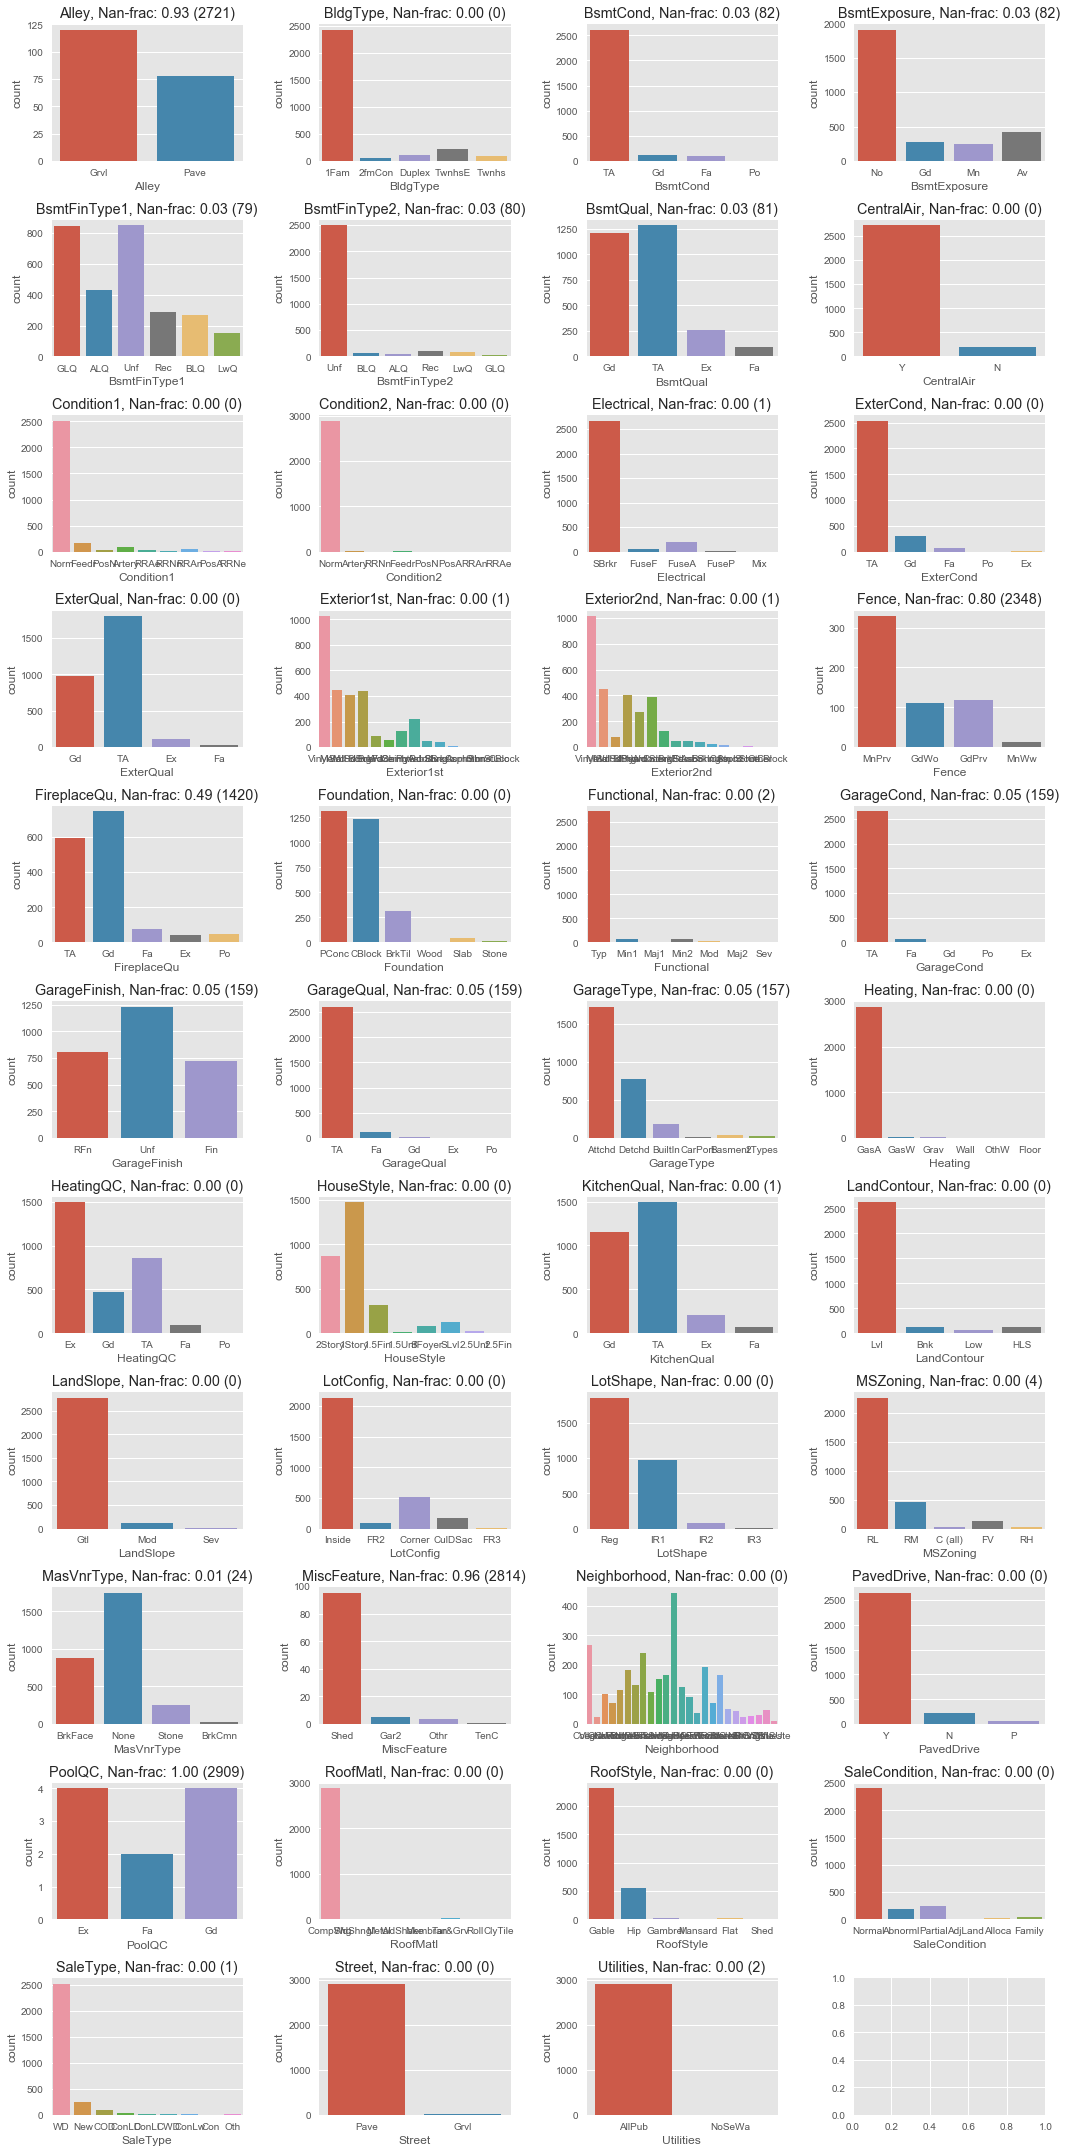

In [42]:
# re-add SalePrice
merged_data = pd.concat([df_train, df_test])

# list variable types
categorical_feature_list = merged_data.select_dtypes(['object']).columns

numerical_feature_list = merged_data.select_dtypes(['int64','float64']).columns


def func(x):
    
    while (x/4).is_integer() == False: x += 1
    return int(x/4)


next_multiple_of_4 = func(merged_data[categorical_feature_list].shape[1])

fig, axes = plt.subplots(next_multiple_of_4,4, figsize=(15,30))

for i, feature in enumerate(categorical_feature_list):
    
    sns.countplot(x=feature, data=merged_data, ax=axes[i // 4][i % 4 ] )
   
    total_nan_for_feature = merged_data[feature].isnull().sum()                                
    
    nan_frac_for_feature = merged_data[feature].isnull().sum() / merged_data[feature].shape[0]
   
    axes[i // 4][i % 4 ].set_title("{}, Nan-frac: {:0.2f} ({})".format(feature, nan_frac_for_feature, \
                                                                       total_nan_for_feature))
    
    
plt.tight_layout()    
plt.show()

In [43]:
def feature_handling_and_value_cleanup(df, intruction_list):
    
    for i, instruction in enumerate(intruction_list):
     
        if instruction[1] == 'None':
            
            pass
        
        elif instruction[1] == 'Mean':
            
            mean = df[instruction[0]].mean()
            
            df[instruction[0]] = df[instruction[0]].fillna(mean)
                                                         
        elif instruction[1] == 'Median':
            
            median = df[instruction[0]].median()
            
            df[instruction[0]] = df[instruction[0]].fillna(median)
        
        elif instruction[1] == 'Drop':
            
            df = df.drop([feature], axis = 1)
            
        elif instruction[1] == 'conv_to_categorical':
        
            merged_data[feature] = merged_data[feature].astype(str)
            
        else:
    
            df[instruction[0]] = df[instruction[0]].fillna(instruction[1])
    
    return df

intruction_list = [('Alley','NA'),
                    ('BldgType','None'),
                    ('BsmtCond','NA'),
                    ('BsmtExposure','NA'),
                    ('BsmtFinType1','NA'),
                    ('BsmtFinType2','NA'),
                    ('BsmtQual','NA'),
                    ('CentralAir','None'),
                    ('Condition1','None'),
                    ('Condition2','None'),
                    ('Electrical','SBrkr'),
                    ('ExterCond','None'),
                    ('ExterQual','None'),
                    ('Exterior1st','VinylSd'),
                    ('Exterior2nd','VinylSd'),
                    ('Fence','NA'),
                    ('FireplaceQu','NA'),
                    ('Foundation','None'),
                    ('Functional','Typ'),
                    ('GarageCond','NA'),
                    ('GarageFinish','NA'),
                    ('GarageQual','NA'),
                    ('GarageType','NA'),
                    ('Heating','None'),
                    ('HeatingQC','None'),
                    ('HouseStyle','None'),
                    ('KitchenQual','TA'),
                    ('LandContour','None'),
                    ('LandSlope','None'),
                    ('LotConfig','None'),
                    ('LotShape','None'),
                    ('MSZoning','RL'),
                    ('MasVnrType','NA'),
                    ('MiscFeature','NA'),
                    ('Neighborhood','None'),
                    ('PavedDrive','NA'),
                    ('PoolQC','NA'),
                    ('RoofMatl','None'),
                    ('RoofStyle','None'),
                    ('SaleCondition','None'),
                    ('SaleType','WD'),
                    ('Street','None'),
                    ('Utilities','AllPub')]

merged_data = feature_handling_and_value_cleanup(merged_data, intruction_list)

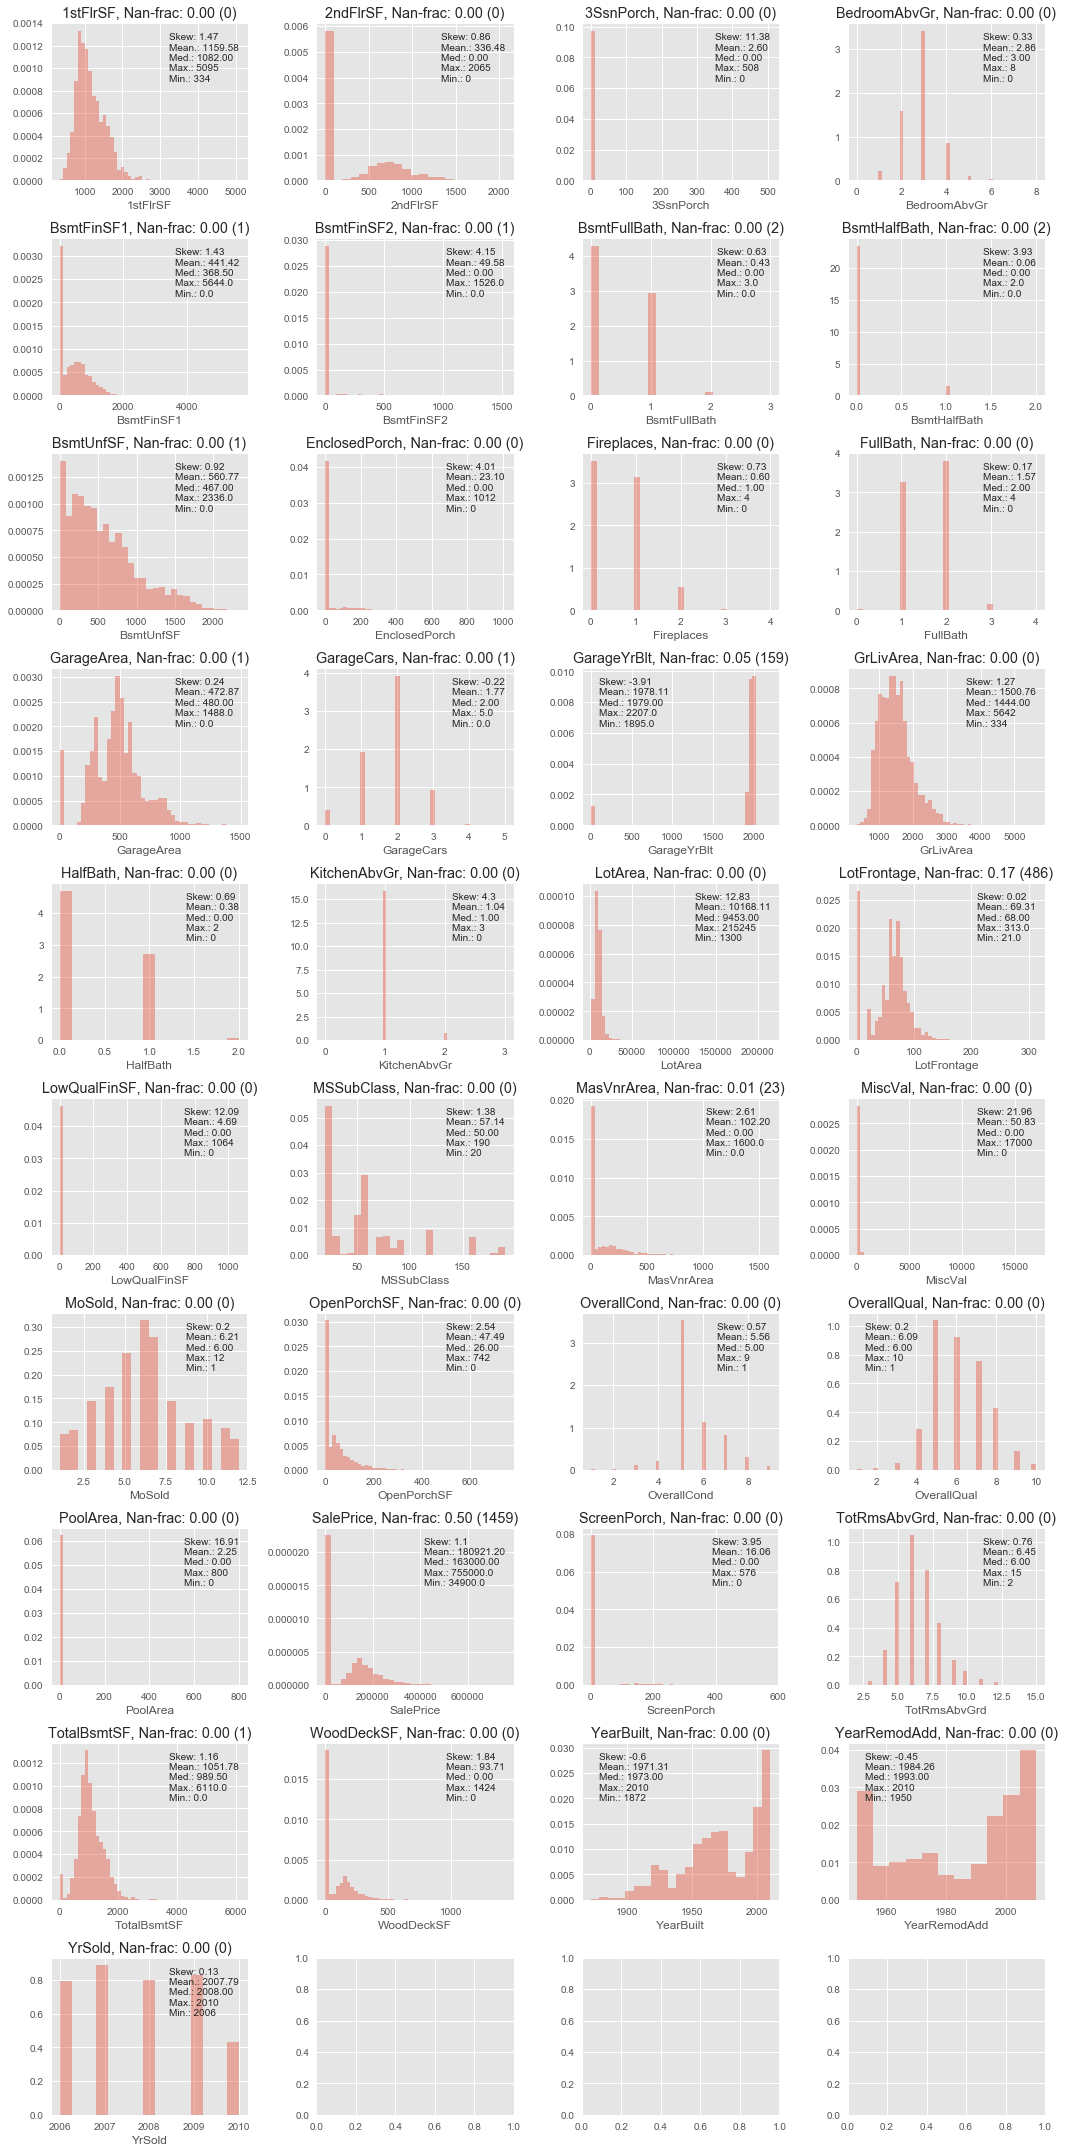

In [44]:
# TODO: replace later. After moving MSSubclass from categorical to numeric the feature lists are deprecated
categorical_feature_list = merged_data.select_dtypes(['object']).columns

numerical_feature_list = merged_data.select_dtypes(['int64','float64']).columns


next_multiple_of_4 = func(merged_data[numerical_feature_list].shape[1])

fig, axes = plt.subplots(next_multiple_of_4,4, figsize=(15,30))

label='SalePrice skew =' + str(round(skewness,2))

for i, feature in enumerate(numerical_feature_list):
    
    min_value = merged_data[feature].min()
    
    max_value = merged_data[feature].max()
    
    mean = merged_data[feature].mean()
    
    median = merged_data[feature].median()
    
    skew = round(merged_data[feature].fillna(0).skew(),2)
  
    sns.distplot(merged_data[feature].fillna(0), ax=axes[i // 4][i % 4 ], kde=False, norm_hist=True, \
                label='Skew: {}\n'
                      'Mean.: {:0.2f}\n'
                      'Med.: {:0.2f}\n'
                      'Max.: {}\n'
                      'Min.: {}\n'.format(skew, mean, median, max_value, min_value))
    
    
    total_nan_for_feature = merged_data[feature].isnull().sum()                                
    
    nan_frac_for_feature = merged_data[feature].isnull().sum() / merged_data[feature].shape[0]
   
    axes[i // 4][i % 4 ].set_title("{}, Nan-frac: {:0.2f} ({})".format(feature, nan_frac_for_feature, \
                                                                      total_nan_for_feature))
    
    axes[i // 4][i % 4 ].legend(handlelength=0)# hide the handle
    
plt.tight_layout()  

plt.show()

In [45]:
instruction_list =[('1stFlrSF','None'),
                    ('2ndFlrSF','None'),
                    ('3SsnPorch','None'),
                    ('BedroomAbvGr','None'),
                    ('BsmtFinSF1',0),
                    ('BsmtFinSF2',0),
                    ('BsmtFullBath',0),
                    ('BsmtHalfBath',1),
                    ('BsmtUnfSF','Mean'),
                    ('EnclosedPorch','None'),
                    ('Fireplaces','None'),
                    ('FullBath','None'),
                    ('GarageArea','Mean'),
                    ('GarageCars',2),
                    ('GarageYrBlt',0),# assume no garage
                    ('GrLivArea','None'),
                    ('HalfBath','None'),
                    ('KitchenAbvGr','None'),
                    ('LotArea','None'),
                    ('LotFrontage','Median'),
                    ('LowQualFinSF','None'),
                    ('MasVnrArea',0),
                    ('MiscVal',0),
                    ('MoSold','None'),
                    ('MSSubClass','conv_to_categorical'),
                    ('OpenPorchSF','None'),
                    ('OverallCond','None'),
                    ('OverallQual','None'),
                    ('PoolArea','None'),
                    ('SalePrice','None'),
                    ('ScreenPorch','None'),
                    ('TotRmsAbvGrd','None'),
                    ('TotalBsmtSF','Median'),
                    ('WoodDeckSF','None'),
                    ('YearBuilt','None'),
                    ('YearRemodAdd','None'),
                    ('YrSold','None')]
df = merged_data
merged_data = feature_handling_and_value_cleanup(merged_data, instruction_list)
df = merged_data

# Prediction with all numerical features

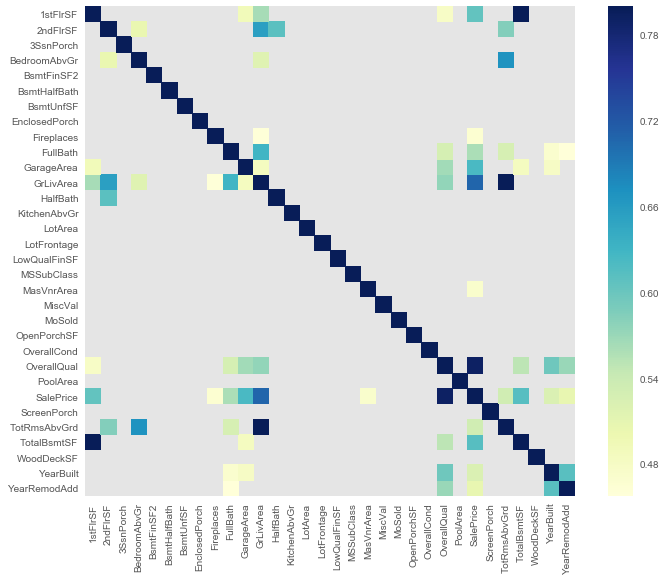

In [46]:
merged_data = df
merged_data = merged_data.select_dtypes(exclude = ['object'])
merged_data = merged_data.drop(['GarageCars','BsmtFullBath','BsmtFinSF1','GarageYrBlt'], axis = 1)

f, ax = plt.subplots(figsize=(12, 9))
merged_data_corr=merged_data.corr(method='pearson')
sns.heatmap(merged_data_corr[merged_data_corr > 0.45], vmax=.8, square=True, cmap="YlGnBu")
plt.show()



In [47]:
df_train = merged_data.loc[merged_data.index <= 1460].copy()

df_test = merged_data.loc[merged_data.index > 1460].copy()

X_train,X_test,Y_train,Y_test = train_test_split(df_train[['GarageArea','GrLivArea']], \
                                df_train['SalePrice'].apply(lambda x:  np.log(x)), \
                                test_size=0.4, random_state=0)

In [48]:
print(X_test.head())
Y_test.head()

     GarageArea  GrLivArea
Id                        
530   484.00000       2515
492   240.00000       1578
460   352.00000       1203
280   505.00000       2022
656   264.00000       1092


Id
530   12.20919
492   11.79810
460   11.60824
280   12.16525
656   11.38509
Name: SalePrice, dtype: float64

In [49]:
Y_train,Y_test = map(lambda x: x.values.reshape(len(x),1),[Y_train,Y_test])

linreg=LinearRegression()


In [50]:
X_train

,GarageArea,GrLivArea
Id,,
1170,807.00000,3627
1147,403.00000,1298
504,484.00000,1801
1450,0.00000,630
1064,440.00000,1103
712,384.00000,1178
802,440.00000,1196
865,529.00000,1372
368,296.00000,1431



 **************** Model statistics on the train set 

Intercept: [ 11.04465556]
Coefficients: [[ 0.00080164  0.00039737]]
Residues: [ 52.46367474]
RMSE: 0.2447244157466799
RMSE by Hand: 0.24472441574667983
LOGRMSE by Hand: 0.020492003178236472
R^2: 0.63697845325

 **************** Model statistics on the test set 

RMSE by Hand: 0.24538487604997936
LOGRMSE by Hand: 0.020106731340349706
R^2: 0.601285197576
R^2 by hand:  0.6012851975760913


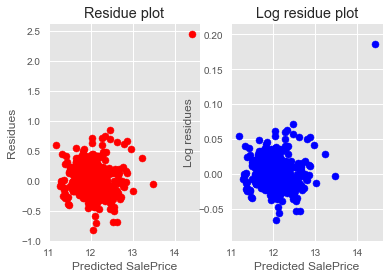


 **************** Model statistics on the train set after revesing the log trafo 

RMSE by Hand: 83437.975863697
LOGRMSE by Hand: 0.24538487604997936
R^2 by hand:  -0.11752476523700661


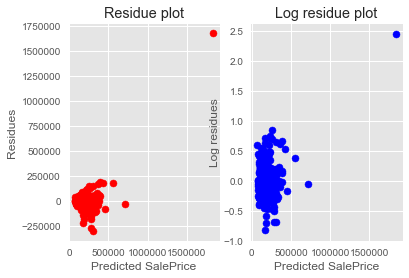

In [51]:
## fit the model to the train split of the training data
# view parameters
linreg.fit(X_train,Y_train)

Y_train_predicted = linreg.predict(X_train)

print("\n **************** Model statistics on the train set \n")

print("Intercept:",linreg.intercept_)

print("Coefficients:", linreg.coef_)

print("Residues:", linreg.residues_)

print("RMSE:", calc_rmse(linreg.residues_, len(X_train)))

calc_rmse_logrmse_by_hand(Y_train_predicted,Y_train, X_train )

#X_train = X_train[['GarageArea','GrLivArea']]

print("R^2:", linreg.score(X_train,Y_train))


## predict the target on the test split of the training data
# view parameters
Y_test_predicted = linreg.predict(X_test)

print("\n **************** Model statistics on the test set \n")

calc_rmse_logrmse_by_hand(Y_test_predicted,Y_test, X_test )

print("R^2:", linreg.score(X_test,Y_test))

calc_r_squared_by_hand(Y_test_predicted,Y_test)

# visualize residues and log residues vs. the predicted SalePrice
plot_residues(Y_test_predicted,Y_test, X_test )


## reverse the log transform and calculate statistics
Y_test = np.apply_along_axis(lambda x: np.exp(x), 1,Y_test)

Y_test_predicted = np.apply_along_axis(lambda x: np.exp(x), 1,Y_test_predicted)

print("\n **************** Model statistics on the train set after revesing the log trafo \n")

calc_rmse_logrmse_by_hand(Y_test_predicted,Y_test, X_test )

calc_r_squared_by_hand(Y_test_predicted,Y_test)

# visualize residues and log residues vs. the predicted SalePrice
plot_residues(Y_test_predicted,Y_test, X_test )


## Output file:take the real test data for submission! 1459 rows!
# index of output file must be 1461 to 2919
#
# prepare test data: select columns, fill missing GaraArea value by median

In [52]:
X_train.shape

(876, 2)

In [53]:
df_test = df_test.drop('SalePrice', axis = 1)


In [54]:
Y_test_predicted = linreg.predict(df_test)

Y_test_predicted = np.apply_along_axis(lambda x: np.exp(x), 1,Y_test_predicted)

makeOutputFile(pd.DataFrame( Y_test_predicted, columns=['SalePrice'], index = range(1461,2920,1)), \
                'SalePrice' ,\
               6
                )

ValueError: shapes (1459,31) and (2,1) not aligned: 31 (dim 1) != 2 (dim 0)

In [ ]:





#trainPredictorValues=df_train['LotArea'].apply(lambda x: x*0.09290304).reshape(len(df_train),1) #Regr method needs (rows, column(s))-array shape.\
                                                                             #  Scale to square meters. ndarray (1,) is 1 dim, (1,y) 2-dim, (x,y,z) 3 dim

#trainTargetValues=df_train['SalePrice'].reshape(len(df_train),1)

#testPredictorVaues=df_test['LotArea'].reshape(len(df_test),1)


In [ ]:
#!jupyter nbconvert --to script the_main_file.ipynb
df_train.OverallQual.value_counts()

In [ ]:
"""
#
 10
down vote
accepted
	

If you want the mean or median you could do something like:

fill_NaN = Imputer(missing_values=np.nan, strategy='mean', axis=1)
imputed_DF = pd.DataFrame(fill_NaN.fit_transform(DF))
imputed_DF.columns = DF.columns(
imputed_DF.index = DF.index

If you want to fill them with 0s or something you could always just do:

DF[DF.isnull()] = 0)




#
https://pandas.pydata.org/pandas-docs/stable/missing_data.h(tm,1))

"""



                            
                            